<a href="https://colab.research.google.com/github/ZeyuWu2001/The-Bidirectional-Relationship-between-Emotional-Change-and-Physical-Movement-Activities/blob/Classification/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package

In [396]:
pip install scikit-mobility googletrans==4.0.0-rc1


In [397]:
import os
import random
import folium
import numpy as np
import pandas as pd
import seaborn as sns
from geopy.distance import great_circle
import networkx as nx
from tqdm import tqdm
from geopy.distance import geodesic
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from folium.plugins import HeatMap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import os
import skmob
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from tqdm import tqdm
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches
from shapely.geometry import Point, LineString

In [398]:
from skmob import TrajDataFrame
from skmob.preprocessing import detection, clustering
from skmob.measures.individual import jump_lengths
from skmob.measures.individual import radius_of_gyration
from skmob.preprocessing import filtering, compression
from skmob.measures.collective import visits_per_location
from skmob.utils.gislib import getDistanceByHaversine
from skmob.measures.collective import homes_per_location
from skmob.measures.individual import home_location
from skmob.measures.individual import jump_lengths, waiting_times, number_of_locations
from skmob.measures.individual import max_distance_from_home, distance_straight_line, maximum_distance
from skmob.measures.individual import individual_mobility_network
from skmob.measures.individual import max_distance_from_home

In [399]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre-Processing

In [400]:
participants_file = "/content/drive/MyDrive/Research/UTokyo/PSM/participants.tsv"
participant = pd.read_csv(participants_file, sep='\t')
participant.drop(columns=['Unnamed: 0'], inplace=True)

locations_file = "/content/drive/MyDrive/Research/UTokyo/PSM/locations.tsv"
location = pd.read_csv(locations_file, sep='\t')
location.drop(columns=['Unnamed: 0'], inplace=True)

emotion_file = "/content/drive/MyDrive/Research/UTokyo/PSM/survey_emotion.tsv"
emotion = pd.read_csv(emotion_file, sep='\t')
emotion.drop(columns=['Unnamed: 0'], inplace=True)

weather_file = "/content/drive/MyDrive/Research/UTokyo/PSM/weather.tsv"
weather = pd.read_csv(weather_file, sep='\t')
weather.drop(columns=['Unnamed: 0'], inplace=True)

pedometer_file = "/content/drive/MyDrive/Research/UTokyo/PSM/pedometer.tsv"
pedometer = pd.read_csv(pedometer_file, sep='\t')
pedometer.drop(columns=['Unnamed: 0'], inplace=True)

In [401]:
# Convert date column to datetime
location['datetime'] = pd.to_datetime(location['datetime'])

# Filter participants dataframe to keep only rows with device IDs present in locations
locations_device_ids = set(location['device_id'].unique())
participants_filtered = participant[participant['device_id'].isin(locations_device_ids)]
participant = participants_filtered
participant = participant.drop_duplicates(subset='device_id')

In [402]:
print(location.date.unique())
print(location.device_id.nunique())
print(participant.device_id.nunique())
print(location.shape)
print(participant.shape)

['2024-02-19' '2024-02-20' '2024-02-21' '2024-02-22' '2024-02-23'
 '2024-02-24' '2024-02-25']
130
130
(388436, 11)
(130, 31)


In [403]:
participant.device_id.nunique()

130

# Merge & Filter

In [404]:
class EmotionStepAnalyzer:
    def __init__(self, participants, weather, pedometer, location, emotion):
        self.participants = participants
        self.weather = weather
        self.pedometer = pedometer
        self.location = location
        self.emotion = emotion
        self.merged_data = None

    def convert_to_datetime(self, df, column_name):
        df[column_name] = pd.to_datetime(df[column_name], errors='coerce', utc=True)
        df = df.dropna(subset=[column_name])  # Drop rows where conversion failed
        return df

    def preprocess_data(self):
        self.weather = self.convert_to_datetime(self.weather[['device_id', 'datetime', 'weather_icon_id', 'timestamp']], 'datetime')
        self.pedometer = self.convert_to_datetime(self.pedometer[['device_id', 'datetime', 'number_of_steps', 'timestamp']], 'datetime')
        self.location = self.convert_to_datetime(self.location[['device_id', 'datetime', 'latitude', 'longitude', 'timestamp']], 'datetime')
        self.emotion = self.convert_to_datetime(self.emotion[['device_id', 'datetime', 'valence', 'arousal']], 'datetime')

    def determine_date_range(self):
        start_date = min(self.weather['datetime'].min(), self.pedometer['datetime'].min(),
                         self.location['datetime'].min(), self.emotion['datetime'].min())
        end_date = max(self.weather['datetime'].max(), self.pedometer['datetime'].max(),
                       self.location['datetime'].max(), self.emotion['datetime'].max())
        return pd.date_range(start=start_date, end=end_date, freq=self.interval)

    def resample_and_interpolate(self, df, datetime_col, date_range):
        df.set_index(datetime_col, inplace=True)
        resampled_list = []
        for device_id, group in df.groupby('device_id'):
            group_resampled = group.resample(self.interval).mean(numeric_only=True)
            group_resampled = group_resampled.reindex(date_range, method='nearest', level=0)
            group_resampled['device_id'] = device_id
            group_resampled = group_resampled.fillna(method='ffill').fillna(method='bfill').interpolate(method='time').reset_index()
            resampled_list.append(group_resampled)
        df_resampled = pd.concat(resampled_list, ignore_index=True)
        df_resampled.rename(columns={'index': datetime_col}, inplace=True)
        return df_resampled

    def calculate_distance_within_intervals(self, df):
        df = df.sort_values('datetime')
        df['prev_latitude'] = df['latitude'].shift(1)
        df['prev_longitude'] = df['longitude'].shift(1)
        df['distance'] = df.apply(
            lambda row: geodesic((row['latitude'], row['longitude']), (row['prev_latitude'], row['prev_longitude'])).meters
            if pd.notnull(row['prev_latitude']) and pd.notnull(row['prev_longitude']) else 0, axis=1)
        return df

    def classify_emotional_state(self, row):
        if row['valence'] > 0 and row['arousal'] > 0:
            return 'pos'
        elif row['valence'] < 0 and row['arousal'] < 0:
            return 'neg'
        elif row['valence'] == 0 and row['arousal'] == 0:
            return 'stable'
        else:
            return 'neutral'

    def classify_emotional_change(self, row):
        if row['prev_emotional_state'] == 'neg' and row['emotional_state'] == 'stable':
            return 'up'
        elif row['prev_emotional_state'] == 'stable' and row['emotional_state'] == 'pos':
            return 'up'
        elif row['prev_emotional_state'] == 'neg' and row['emotional_state'] == 'pos':
            return 'up'
        elif row['prev_emotional_state'] == 'stable' and row['emotional_state'] == 'neg':
            return 'down'
        elif row['prev_emotional_state'] == 'pos' and row['emotional_state'] == 'stable':
            return 'down'
        elif row['prev_emotional_state'] == 'pos' and row['emotional_state'] == 'neg':
            return 'down'
        elif row['prev_emotional_state'] == row['emotional_state']:
            return 'stable'
        else:
            return 'neutral'

    def classify_emotional_change_binary(self, row):
        return 1 if row in ['up', 'down'] else 0

    def prepare_data(self, interval='H'):
        self.interval = interval
        self.preprocess_data()
        date_range = self.determine_date_range()

        user_weather_resampled = self.resample_and_interpolate(self.weather, 'datetime', date_range)
        user_step_resampled = self.resample_and_interpolate(self.pedometer, 'datetime', date_range)
        user_location_resampled = self.resample_and_interpolate(self.location, 'datetime', date_range)
        user_location_resampled = user_location_resampled.groupby('device_id').apply(self.calculate_distance_within_intervals)

        user_emotion_resampled = self.resample_and_interpolate(self.emotion, 'datetime', date_range)
        user_emotion_resampled['emotional_state'] = user_emotion_resampled.apply(self.classify_emotional_state, axis=1)
        user_emotion_resampled['prev_emotional_state'] = user_emotion_resampled.groupby('device_id')['emotional_state'].shift(1)
        user_emotion_resampled['emotional_change'] = user_emotion_resampled.apply(self.classify_emotional_change, axis=1)
        user_emotion_resampled['emotional_change_binary'] = user_emotion_resampled['emotional_change'].apply(self.classify_emotional_change_binary)

        self.merged_data = self.participants.merge(user_location_resampled, on='device_id').merge(
            user_emotion_resampled, on=['device_id', 'datetime']).merge(
            user_step_resampled, on=['device_id', 'datetime']).merge(
            user_weather_resampled, on=['device_id', 'datetime'])

        self.merged_data = self.merged_data[self.merged_data['emotional_change'].isin(['up', 'down', 'stable'])]
        self.merged_data['emotional_change_binary'] = self.merged_data['emotional_change'].apply(self.classify_emotional_change_binary)

        # Define commuting status
        office_freq_mapping = {
            '出社しない（=全て在宅勤務）': 'WFH',
            '週に5回以上': '5 times a week',
            '週に4回': '4 times a week',
            '週に3回': '3 times a week',
            '週に2回': 'twice a week',
            '週に1回': 'once a week',
            '月に1回': 'once a month',
            'その他': 'other'
        }
        self.merged_data['office'] = self.merged_data['office'].map(office_freq_mapping)

        # Define age groups
        self.merged_data['age_group'] = pd.cut(self.merged_data['age'], bins=[0, 14, 17, 24, 35, 45, 65, float('inf')], labels=['Minor', 'Young Youth', 'Middle Youth', 'Elder Youth', 'Middle Ages', 'Elder Ages', 'Elders'])

        # Define region groups
        location_mapping = {
            '神奈川県': 'Urban',
            '東京都': 'Urban',
            '大阪府': 'Urban',
            '京都府': 'Urban',
            '福岡県': 'Urban',
            '静岡県': 'Rural',
            '愛知県': 'Rural',
            '北海道': 'Rural',
            '富山県': 'Rural',
            '福島県': 'Rural',
            '熊本県': 'Rural',
            '栃木県': 'Rural',
            '佐賀県': 'Rural',
            '滋賀県': 'Rural',
            '高知県': 'Rural',
            '奈良県': 'Rural',
            '千葉県': 'Rural',
            '埼玉県': 'Rural',
            '新潟県': 'Rural',
            '三重県': 'Rural',
            '宮城県': 'Rural',
            '石川県': 'Rural',
            '兵庫県': 'Rural',
            '広島県': 'Rural',
            '沖縄県': 'Rural',
            '群馬県': 'Rural',
            '岡山県': 'Rural',
            '秋田県': 'Rural',
            '茨城県': 'Rural',
            '長野県': 'Rural',
            '愛媛県': 'Rural',
            '青森県': 'Rural',
            '鹿児島県': 'Rural'
        }
        self.merged_data['region'] = self.merged_data['location'].map(location_mapping)

        number_of_children_mapping = {
            '0人': '0',
            '1人': '1',
            '2人': '2',
            '3人': '3',
            '4人以上': '4'
        }
        self.merged_data['number_of_children'] = self.merged_data['number_of_children'].map(number_of_children_mapping)

        # Define education groups
        education_mapping = {
            '高校卒業': 'lower edu',
            '大学卒業': 'higher edu',
            '専門学校卒業': 'lower edu',
            '大学院（修士課程）卒業': 'higher edu',
            '短期大学卒業': 'lower edu',
            'その他': 'lower edu'
        }
        self.merged_data['education'] = self.merged_data['education'].map(education_mapping)

        # Define gender groups
        gender_mapping = {
            '男性': 'Male',
            '女性': 'Female'
        }
        self.merged_data['gender'] = self.merged_data['gender'].map(gender_mapping)

        # Ensure necessary columns for analysis
        self.merged_data = self.merged_data.dropna(subset=['longitude', 'latitude', 'number_of_steps', 'distance', 'emotional_change'])

        return self.merged_data

    def plot_data(self, num_users=10):
        # Set random seed for reproducibility
        random.seed(100)

        # Select random unique device IDs
        selected_users = random.sample(list(self.merged_data['device_id'].unique()), num_users)

        # Filter the data for the selected users
        filtered_data = self.merged_data[self.merged_data['device_id'].isin(selected_users)]

        # Plot steps, distance, longitude, latitude, valence, and arousal over time in subplots
        fig, axs = plt.subplots(6, 1, figsize=(12, 22), sharex=True)

        # Plot steps over time
        for device_id, group in filtered_data.groupby('device_id'):
            axs[0].plot(group['datetime'], group['number_of_steps'], label=f'{device_id}', alpha=0.7)
        axs[0].set_title('Steps Over Time')
        axs[0].set_ylabel('Number of Steps')

        # Plot distance over time
        for device_id, group in filtered_data.groupby('device_id'):
            axs[1].plot(group['datetime'], group['distance'], label=f'{device_id}', alpha=0.7)
        axs[1].set_title('Distance Over Time')
        axs[1].set_ylabel('Distance (meters)')

        # Plot longitude over time
        for device_id, group in filtered_data.groupby('device_id'):
            axs[2].plot(group['datetime'], group['longitude'], label=f'{device_id}', alpha=0.7)
        axs[2].set_title('Longitude Over Time')
        axs[2].set_ylabel('Longitude')

        # Plot latitude over time
        for device_id, group in filtered_data.groupby('device_id'):
            axs[3].plot(group['datetime'], group['latitude'], label=f'{device_id}', alpha=0.7)
        axs[3].set_title('Latitude Over Time')
        axs[3].set_ylabel('Latitude')

        # Plot valence over time
        for device_id, group in filtered_data.groupby('device_id'):
            axs[4].plot(group['datetime'], group['valence'], label=f'{device_id}', alpha=0.7)
        axs[4].set_title('Valence Over Time')
        axs[4].set_ylabel('Valence')

        # Plot arousal over time
        for device_id, group in filtered_data.groupby('device_id'):
            axs[5].plot(group['datetime'], group['arousal'], label=f'{device_id}', alpha=0.7)
        axs[5].set_title('Arousal Over Time')
        axs[5].set_ylabel('Arousal')
        axs[5].set_xlabel('Time')

        # Add the legend outside the plots
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(selected_users))

        plt.tight_layout()
        plt.show()

<ipython-input-404-79cb2285d977>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = pd.to_datetime(df[column_name], errors='coerce', utc=True)
<ipython-input-404-79cb2285d977>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = pd.to_datetime(df[column_name], errors='coerce', utc=True)
<ipython-input-404-79cb2285d977>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

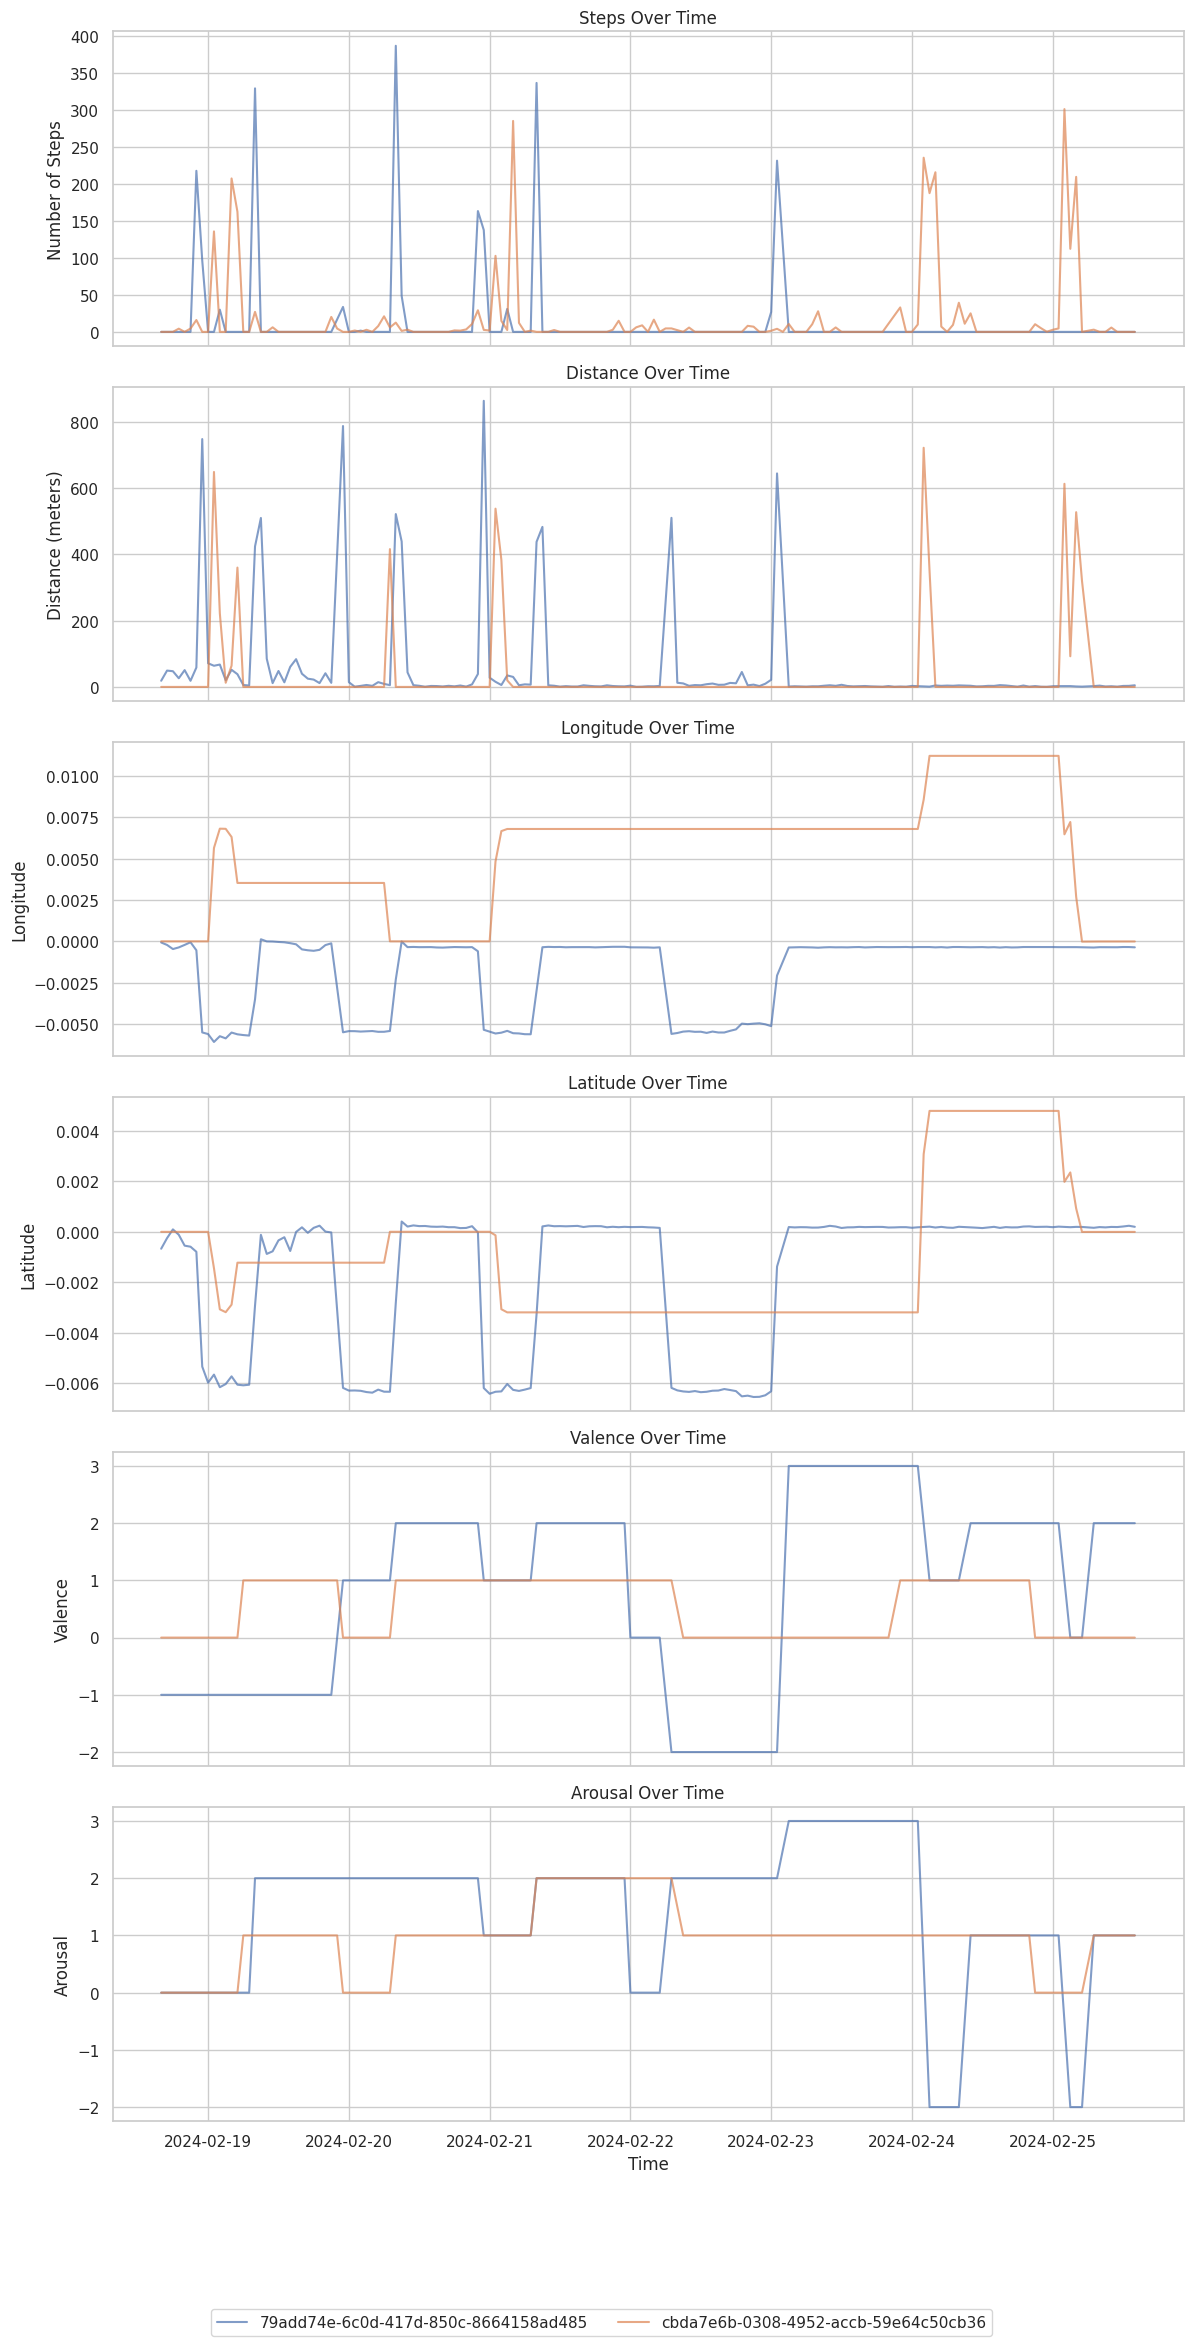

In [405]:
analyzer = EmotionStepAnalyzer(participant, weather, pedometer, location, emotion)
merged_data = analyzer.prepare_data(interval='H') # Set the interval ('H' for hourly, '12H' for 12-hourly, 'D' for daily)
analyzer.plot_data(num_users=2)  # Set the number of users to plot

In [406]:
merged_data = merged_data[['device_id', 'age', 'location',
              'commutation', 'commutation_method',
              'job', 'nurture', 'office', 'gender', 'age_group', 'region', 'education', 'number_of_children',
              'datetime', 'timestamp', 'timestamp_x', 'timestamp_y',
              'latitude', 'longitude', 'prev_latitude', 'prev_longitude',
              'valence', 'arousal', 'emotional_state', 'prev_emotional_state',
              'number_of_steps',
              'distance']]

In [407]:
Filter_ID = merged_data.device_id.unique()
location = location[location['device_id'].isin(Filter_ID)]
participant = participant[participant['device_id'].isin(Filter_ID)]
emotion = emotion[emotion['device_id'].isin(Filter_ID)]
pedometer = pedometer[pedometer['device_id'].isin(Filter_ID)]
weather = weather[weather['device_id'].isin(Filter_ID)]

In [408]:
print(location.date.unique())
print(location.device_id.nunique())
print(participant.device_id.nunique())

['2024-02-19' '2024-02-20' '2024-02-21' '2024-02-22' '2024-02-23'
 '2024-02-24' '2024-02-25']
123
123


# Create Subgroup & Translate

In [409]:
merged_df = pd.merge(location, participant[['device_id', 'age', 'location', 'gender', 'job', 'office', 'family', 'nurture', 'education', 'number_of_children']], on='device_id', how='left')
merged_df.shape

(366064, 20)

In [410]:
# Gender Group
gender_mapping = {
            '男性': 'Male',
            '女性': 'Female'
        }
merged_df['gender'] = merged_df['gender'].map(gender_mapping)
participant['gender'] = participant['gender'].map(gender_mapping)

Male = merged_df[merged_df['gender'] == 'Male']
Female = merged_df[merged_df['gender'] == 'Female']

# Work Communting Group
office_freq_mapping = {
    '出社しない（=全て在宅勤務）': 'WFH',
    '週に5回以上': '5 times a week',
    '週に4回': '4 times a week',
    '週に3回': '3 times a week',
    '週に2回': 'twice a week',
    '週に1回': 'once a week',
    '月に1回': 'once a month',
    'その他': 'other'
}

merged_df['office'] = merged_df['office'].map(office_freq_mapping)
participant['office'] = participant['office'].map(office_freq_mapping)

WFH = merged_df[merged_df['office'] == 'WFH']
five_times = merged_df[merged_df['office'] == '5 times a week']
four_times = merged_df[merged_df['office'] == '4 times a week']
three_times = merged_df[merged_df['office'] == '3 times a week']
two_times = merged_df[merged_df['office'] == 'twice a month']
one_time = merged_df[merged_df['office'] == 'once a week']
one_month = merged_df[merged_df['office'] == 'once a month']
other_communting = merged_df[merged_df['office'] == 'other']

# Job Status Group Mapping
job_status_mapping = {
    '自営業': 'Self-employed',
    '会社員': 'Company employee',
    '公務員': 'Government employee',
    'パート・アルバイト': 'Part-time job',
    '学生': 'Student',
    '無職': 'Unemployed',
    'その他': 'Other'
}
merged_df['job'] = merged_df['job'].map(job_status_mapping)
participant['job'] = participant['job'].map(job_status_mapping)

self_employed = merged_df[merged_df['job'] == 'Self-employed']
company_employee = merged_df[merged_df['job'] == 'Company employee']
government_employee = merged_df[merged_df['job'] == 'Government employee']
part_time_job = merged_df[merged_df['job'] == 'Part-time job']
student = merged_df[merged_df['job'] == 'Student']
unemployed = merged_df[merged_df['job'] == 'Unemployed']
other_job = merged_df[merged_df['job'] == 'Other']

# Location Group
region_mapping = {
                '神奈川県': 'Urban',
                '東京都': 'Urban',
                '大阪府': 'Urban',
                '京都府': 'Urban',
                '静岡県': 'Rural',
                '愛知県': 'Rural',
                '北海道': 'Rural',
                '富山県': 'Rural',
                '福島県': 'Rural',
                '熊本県': 'Rural',
                '栃木県': 'Rural',
                '福岡県': 'Rural',
                '佐賀県': 'Rural',
                '滋賀県': 'Rural',
                '高知県': 'Rural',
                '奈良県': 'Rural',
                '千葉県': 'Rural',
                '埼玉県': 'Rural',
                '新潟県': 'Rural',
                '三重県': 'Rural',
                '宮城県': 'Rural',
                '石川県': 'Rural',
                '兵庫県': 'Rural',
                '広島県': 'Rural',
                '沖縄県': 'Rural',
                '群馬県': 'Rural',
                '岡山県': 'Rural',
                '秋田県': 'Rural',
                '茨城県': 'Rural',
                '長野県': 'Rural',
                '愛媛県': 'Rural',
                '青森県': 'Rural',
                '鹿児島県': 'Rural'
            }
merged_df['region'] = merged_df['location'].map(region_mapping)
participant['region'] = participant['location'].map(region_mapping)

Urban = merged_df[merged_df['region'] == 'Urban']
Rural = merged_df[merged_df['region'] == 'Rural']

location_mapping = {
    '京都府': 'Kinki',
    '大阪府': 'Kinki',
    '東京都': 'Kanto',
    '神奈川県': 'Kanto',
    '静岡県': 'Tokai',
    '愛知県': 'Tokai',
    '北海道': 'Hokkaido',
    '富山県': 'Chubu',
    '福島県': 'Tohoku',
    '熊本県': 'Kyushu',
    '栃木県': 'Kanto',
    '福岡県': 'Kyushu',
    '佐賀県': 'Kyushu',
    '滋賀県': 'Kinki',
    '高知県': 'Shikoku',
    '奈良県': 'Kinki',
    '千葉県': 'Kanto',
    '埼玉県': 'Kanto',
    '新潟県': 'Chubu',
    '三重県': 'Kinki',
    '宮城県': 'Tohoku',
    '鹿児島県': 'Kyushu',
    '石川県': 'Chubu',
    '兵庫県': 'Kinki',
    '広島県': 'Chugoku',
    '沖縄県': 'Okinawa',
    '群馬県': 'Kanto',
    '岡山県': 'Chugoku',
    '秋田県': 'Tohoku',
    '茨城県': 'Kanto',
    '長野県': 'Chubu',
    '愛媛県': 'Shikoku',
    '青森県': 'Tohoku'
}
merged_df['location'] = merged_df['location'].map(location_mapping)
participant['location'] = participant['location'].map(location_mapping)

number_of_children_mapping = {
            '0人': '0',
            '1人': '1',
            '2人': '2',
            '3人': '3',
            '4人以上': '4'
        }
merged_df['number_of_children'] = merged_df['number_of_children'].map(number_of_children_mapping)
participant['number_of_children'] = participant['number_of_children'].map(number_of_children_mapping)

# Define education groups
education_mapping = {
            '高校卒業': 'lower edu',
            '大学卒業': 'higher edu',
            '専門学校卒業': 'lower edu',
            '大学院（修士課程）卒業': 'higher edu',
            '短期大学卒業': 'lower edu',
            'その他': 'lower edu'
        }
merged_df['education'] = merged_df['education'].map(education_mapping)
participant['education'] = participant['education'].map(education_mapping)

# Family Status Group
family_status_mapping = {
    'その他': 'Other',
    '一人暮らし': 'Living alone',
    '子供@親': 'Child with parents',
    '配偶者': 'Spouse',
    '親': 'Parents',
    '配偶者@子供': 'Spouse with children',
    '配偶者@子供@親': 'Spouse with children and parents',
    '子供': 'Children',
    '兄弟姉妹': 'Siblings',
    '親@兄弟姉妹': 'Parents with siblings'
}
merged_df['family'] = merged_df['family'].map(family_status_mapping)
participant['family'] = participant['family'].map(family_status_mapping)

# Nurture Status Group
nurture_status_mapping = {
    '子供は居ない': 'No children',
    '利用していない': 'Not using',
    '利用している': 'Using'
}
merged_df['nurture'] = merged_df['nurture'].map(nurture_status_mapping)
participant['nurture'] = participant['nurture'].map(nurture_status_mapping)

# Age Group
merged_df['age_group'] = pd.cut(merged_df['age'], bins=[0, 14, 17, 24, 35, 45, 65, float('inf')],
                                labels=['Minor', 'Young Youth', 'Middle Youth', 'Elder Youth', 'Middle Ages', 'Elder Ages', 'Elders'])
participant['age_group'] = pd.cut(participant['age'], bins=[0, 14, 17, 24, 35, 45, 65, float('inf')],
                                  labels=['Minor', 'Young Youth', 'Middle Youth', 'Elder Youth', 'Middle Ages', 'Elder Ages', 'Elders'])

# Grouping based on revised age groups
Minor = merged_df[merged_df['age_group'] == 'Minor']
Young_youth = merged_df[merged_df['age_group'] == 'Young Youth']
Middle_youth = merged_df[merged_df['age_group'] == 'Middle Youth']
Elder_youth = merged_df[merged_df['age_group'] == 'Elder Youth']
Middle_ages = merged_df[merged_df['age_group'] == 'Middle Ages']
Elder_ages = merged_df[merged_df['age_group'] == 'Elder Ages']
Elders = merged_df[merged_df['age_group'] == 'Elders']

<ipython-input-410-5bbeeec1c2a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant['gender'] = participant['gender'].map(gender_mapping)
<ipython-input-410-5bbeeec1c2a1>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant['office'] = participant['office'].map(office_freq_mapping)
<ipython-input-410-5bbeeec1c2a1>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

# Processing

In [411]:
merged_df.columns

Index(['timestamp', 'device_id', 'speed', 'bearing', 'altitude', 'latitude',
       'longitude', 'accuracy', 'datetime', 'hour', 'date', 'age', 'location',
       'gender', 'job', 'office', 'family', 'nurture', 'education',
       'number_of_children', 'region', 'age_group'],
      dtype='object')

In [412]:
# Ensure the DataFrame is sorted by device_id and datetime
merged_df = merged_df.sort_values(by=['device_id', 'datetime'])

tdf = skmob.TrajDataFrame(merged_df, latitude='latitude', longitude='longitude', datetime='datetime', user_id='device_id')
tdf['leaving_datetime'] = tdf.datetime  # this field is added to add stops later
ftdf = filtering.filter(tdf, max_speed_kmh=500.0, include_loops=True, ratio_max=1)  # Speed Noise filtering
ctdf = compression.compress(ftdf, spatial_radius_km=.2)  # Trajectory compression
stdf = detection.stay_locations(ctdf, stop_radius_factor=0.5, minutes_for_a_stop=20.0, spatial_radius_km=0.2, leaving_time=True) # stay location detection
stdf['leaving_datetime'] = pd.to_datetime(stdf['leaving_datetime'])
stdf['datetime'] = pd.to_datetime(stdf['datetime'])
cl_stdf = clustering.cluster(stdf, cluster_radius_km=0.3)  # cluster stop locations

In [413]:
dist = np.zeros([len(cl_stdf),1])
for i in range(len(cl_stdf)-1):
    dist[i+1] = getDistanceByHaversine((cl_stdf['lat'][i], cl_stdf['lng'][i]),
              (cl_stdf['lat'][i+1], cl_stdf['lng'][i+1]))
cl_stdf['distance (km)'] = dist

def calc_stay_duration(data):
    td = data['leaving_datetime']-data['datetime']
    return td.seconds/3600

cl_stdf['stay_duration(hr)'] = cl_stdf.apply(calc_stay_duration, axis = 1)

# Convert cl_stdf back to DataFrame for further analysis
df_cl_stdf = pd.DataFrame(cl_stdf)
# Extract date from datetime
df_cl_stdf['date'] = df_cl_stdf['datetime'].dt.date
# Calculate the day of the week for each date (0 = Monday, 6 = Sunday)
df_cl_stdf['day_of_week'] = df_cl_stdf['datetime'].dt.dayofweek

In [414]:
# Feature extraction
# Calculate distance traveled for each point
df_cl_stdf['prev_lat'] = df_cl_stdf.groupby('uid')['lat'].shift(1)
df_cl_stdf['prev_lng'] = df_cl_stdf.groupby('uid')['lng'].shift(1)
df_cl_stdf['dist_to_prev'] = df_cl_stdf.apply(lambda row: geodesic((row['lat'], row['lng']), (row['prev_lat'], row['prev_lng'])).km if pd.notnull(row['prev_lat']) else 0, axis=1)

# Aggregate features by user
user_features = df_cl_stdf.groupby('uid').agg({
    # 'lat': ['mean', 'std'],
    # 'lng': ['mean', 'std'],
    'dist_to_prev': ['sum', 'mean', 'std'],
    # 'datetime': ['count']
}).reset_index()

# Flatten the MultiIndex columns
user_features.columns = ['_'.join(col).strip() for col in user_features.columns.values]
user_features = user_features.rename(columns={'uid_': 'uid'})

## Trip Count

In [415]:
# Group by user ID (uid), date, and day of the week to count the number of trips
trip_counts_per_day = df_cl_stdf.groupby(['uid', 'date', 'day_of_week']).size().reset_index(name='trip_count')

# Pivot the table to have days of the week as columns (fill missing values with 0: , fill_value=0)
pivoted = trip_counts_per_day.pivot_table(index='uid', columns='day_of_week', values='trip_count')

# Rename columns for clarity
pivoted.columns = ['trips_Mon', 'trips_Tue', 'trips_Wed', 'trips_Thu', 'trips_Fri', 'trips_Sat', 'trips_Sun']

# Calculate the average number of trips per weekday and per weekend
pivoted['mean_trips_weekday'] = pivoted[['trips_Mon', 'trips_Tue', 'trips_Wed', 'trips_Thu', 'trips_Fri']].mean(axis=1)
pivoted['mean_trips_weekend'] = pivoted[['trips_Sat', 'trips_Sun']].mean(axis=1)
pivoted['mean_trips_week'] = pivoted[['trips_Mon', 'trips_Tue', 'trips_Wed', 'trips_Thu', 'trips_Fri', 'trips_Sat', 'trips_Sun']].mean(axis=1)

# Reset the index to have 'uid' as a column
pivoted.reset_index(inplace=True)

# Select the final columns for the output dataframe
average_trips_user_df = pivoted[['uid', 'mean_trips_week', 'mean_trips_weekday', 'mean_trips_weekend', 'trips_Mon', 'trips_Tue', 'trips_Wed', 'trips_Thu', 'trips_Fri', 'trips_Sat', 'trips_Sun']]
average_trips_user_df.head()

uid  mean_trips_week  mean_trips_weekday  \
0  04c9a764-afd1-4e61-a6ce-775069b1d338         2.166667                 2.0   
1  065e34c8-cacc-4072-81fb-71b250e41b36         3.400000                 3.5   
2  0738c538-8510-4712-8984-fd47447367df         3.000000                 2.6   
3  0839d57b-998b-44b9-bfa7-aaa3a14f164b         4.750000                 5.0   
4  0a796def-4c46-41fe-a0f8-d66b0224124e         3.714286                 3.4   

   mean_trips_weekend  trips_Mon  trips_Tue  trips_Wed  trips_Thu  trips_Fri  \
0                 3.0        1.0        3.0        1.0        4.0        1.0   
1                 3.0        5.0        2.0        3.0        4.0        NaN   
2                 4.0        3.0        2.0        2.0        3.0        3.0   
3                 4.5        5.0        NaN        NaN        NaN        5.0   
4                 4.5        4.0        3.0        3.0        5.0        2.0   

   trips_Sat  trips_Sun  
0        NaN        3.0  
1        3.0        NaN  
2        6.0        2.0  
3        4.0        5.0  
4        7.0        2.0

## Stay Count

In [416]:
# Group by user ID (uid), date, and day of the week to count the number of stays
stay_counts_per_day = df_cl_stdf.groupby(['uid', 'date', 'day_of_week']).size().reset_index(name='stay_count')

# Pivot the table to have days of the week as columns (fill missing values with 0)
pivoted_stays = stay_counts_per_day.pivot_table(index='uid', columns='day_of_week', values='stay_count', fill_value=0)

# Rename columns for clarity
pivoted_stays.columns = ['stays_Mon', 'stays_Tue', 'stays_Wed', 'stays_Thu', 'stays_Fri', 'stays_Sat', 'stays_Sun']

# Calculate the average number of stays per weekday and per weekend
pivoted_stays['mean_stays_weekday'] = pivoted_stays[['stays_Mon', 'stays_Tue', 'stays_Wed', 'stays_Thu', 'stays_Fri']].mean(axis=1)
pivoted_stays['mean_stays_weekend'] = pivoted_stays[['stays_Sat', 'stays_Sun']].mean(axis=1)
pivoted_stays['mean_stays_week'] = pivoted_stays[['stays_Mon', 'stays_Tue', 'stays_Wed', 'stays_Thu', 'stays_Fri', 'stays_Sat', 'stays_Sun']].mean(axis=1)

# Reset the index to have 'uid' as a column
pivoted_stays.reset_index(inplace=True)

# Select the final columns for the output dataframe
stay_numbers_user_df = pivoted_stays[['uid', 'mean_stays_week', 'mean_stays_weekday', 'mean_stays_weekend', 'stays_Mon', 'stays_Tue', 'stays_Wed', 'stays_Thu', 'stays_Fri', 'stays_Sat', 'stays_Sun']]
stay_numbers_user_df.head()

uid  mean_stays_week  mean_stays_weekday  \
0  04c9a764-afd1-4e61-a6ce-775069b1d338         1.857143                 2.0   
1  065e34c8-cacc-4072-81fb-71b250e41b36         2.428571                 2.8   
2  0738c538-8510-4712-8984-fd47447367df         3.000000                 2.6   
3  0839d57b-998b-44b9-bfa7-aaa3a14f164b         2.714286                 2.0   
4  0a796def-4c46-41fe-a0f8-d66b0224124e         3.714286                 3.4   

   mean_stays_weekend  stays_Mon  stays_Tue  stays_Wed  stays_Thu  stays_Fri  \
0                 1.5          1          3          1          4          1   
1                 1.5          5          2          3          4          0   
2                 4.0          3          2          2          3          3   
3                 4.5          5          0          0          0          5   
4                 4.5          4          3          3          5          2   

   stays_Sat  stays_Sun  
0          0          3  
1          3          0  
2          6          2  
3          4          5  
4          7          2

## Mobility Metrics

In [417]:
tdf = TrajDataFrame(df_cl_stdf)
# Separate Weekday and Weekend Stay Duration
# tdf['day_of_week'] = tdf['datetime'].dt.dayofweek
weekday_tdf = tdf[tdf['day_of_week'] < 5]
weekend_tdf = tdf[tdf['day_of_week'] >= 5]
weekday_stays = tdf[tdf['day_of_week'] < 5]
weekend_stays = tdf[tdf['day_of_week'] >= 5]
weekday_travels = tdf[tdf['day_of_week'] < 5]
weekend_travels = tdf[tdf['day_of_week'] >= 5]

# Calculate Home Location
home_loc = home_location(tdf)
# Calculate Radius of Gyration
rog = radius_of_gyration(tdf)

# Calculate Radius of Gyration per user for weekday and weekend separately
weekday_rog = radius_of_gyration(weekday_tdf, show_progress=False)
weekend_rog = radius_of_gyration(weekend_tdf, show_progress=False)
# Calculate Total Stay Duration
Total_stay_duration = tdf.groupby('uid').apply(lambda x: (x['leaving_datetime'] - x['datetime']).sum()).reset_index(name='stay_duration')

# Calculate Total Stay Duration per user for weekday and weekend separately
Total_weekday_stay_duration = weekday_stays.groupby('uid').apply(lambda x: (x['leaving_datetime'] - x['datetime']).sum()).reset_index(name='weekday_stay_duration')
Total_weekend_stay_duration = weekend_stays.groupby('uid').apply(lambda x: (x['leaving_datetime'] - x['datetime']).sum()).reset_index(name='weekend_stay_duration')

# Calculate Total Travel Distance
Total_travel_distances = tdf.groupby('uid')['distance (km)'].sum().reset_index(name='total_travel_distance')

# Calculate Total Travel Distance per user for weekday and weekend separately
Total_weekday_travel_distances = weekday_travels.groupby('uid')['distance (km)'].sum().reset_index(name='weekday_travel_distance')
Total_weekend_travel_distances = weekend_travels.groupby('uid')['distance (km)'].sum().reset_index(name='weekend_travel_distance')

# Merge the results into a single DataFrame

all_users = pd.DataFrame({'uid': tdf['uid'].unique()})  # Create a DataFrame with all unique user IDs

# Merging the dataframes
final_user_df = all_users.merge(average_trips_user_df, on='uid', how='outer') \
                         .merge(stay_numbers_user_df, on='uid', how='outer') \
                         .merge(home_loc, on='uid', how='outer') \
                         .merge(rog, on='uid', how='outer') \
                         .merge(weekday_rog, on='uid', how='outer') \
                         .merge(weekend_rog, on='uid', how='outer') \
                         .merge(Total_stay_duration, on='uid', how='outer') \
                         .merge(Total_weekday_stay_duration, on='uid', how='outer') \
                         .merge(Total_weekend_stay_duration, on='uid', how='outer') \
                         .merge(Total_travel_distances, on='uid', how='outer') \
                         .merge(Total_weekday_travel_distances, on='uid', how='outer') \
                         .merge(Total_weekend_travel_distances, on='uid', how='outer')

# Filling NaN values appropriately
final_user_df = final_user_df.fillna({
    'average_trip_count_per_day': 0,
    'mean_trips_week': 0,
    'mean_trips_weekday': 0,
    'mean_trips_weekend': 0,
    'trips_Mon': 0,
    'trips_Tue': 0,
    'trips_Wed': 0,
    'trips_Thu': 0,
    'trips_Fri': 0,
    'trips_Sat': 0,
    'trips_Sun': 0,
    'stay_numbers_all_days': 0,
    'mean_stay_week': 0,
    'mean_stay_weekday': 0,
    'mean_stay_weekend': 0,
    'home_location': (0, 0),  # home_location is a tuple
    'radius_of_gyration': 0,
    'weekday_radius_of_gyration': 0,
    'weekend_radius_of_gyration': 0,
    'Total_stay_duration': pd.Timedelta(0),
    'Total_weekday_stay_duration': pd.Timedelta(0),
    'Total_weekend_stay_duration': pd.Timedelta(0),
    'Total_travel_distance': 0,
    'Total_weekday_travel_distance': 0,
    'Total_weekend_travel_distance': 0
})

100%|██████████| 117/117 [00:00<00:00, 874.01it/s]


## Emotion Metrics

In [418]:
# Function to rename and filter dates
def rename_and_filter_dates(df, score_column, prefix):
    date_map = {
        '2024-02-19': f'{prefix} Mon',
        '2024-02-20': f'{prefix} Tue',
        '2024-02-21': f'{prefix} Wed',
        '2024-02-22': f'{prefix} Thu',
        '2024-02-23': f'{prefix} Fri',
        '2024-02-24': f'{prefix} Sat',
        '2024-02-25': f'{prefix} Sun'
    }

    df_filtered = df[df['date'].isin(date_map.keys())]
    df_filtered = df_filtered.groupby(['device_id', 'date'])[score_column].mean().reset_index()
    df_filtered = df_filtered.pivot(index='device_id', columns='date', values=score_column)
    df_filtered.rename(columns=date_map, inplace=True)

    return df_filtered

valence_filtered = rename_and_filter_dates(emotion, 'valence', 'valence')
arousal_filtered = rename_and_filter_dates(emotion, 'arousal', 'arousal')

# Merge the datasets on 'device_id'
emotion_df = emotion.merge(valence_filtered, on='device_id', how='outer')
emotion_df = emotion_df.merge(arousal_filtered, on='device_id', how='outer')

In [419]:
# Add the scores back to the emotion_df dataframe, ensuring uniqueness by grouping and averaging
valence_scores = emotion.groupby('device_id')[['valence']].mean().reset_index()
arousal_scores = emotion.groupby('device_id')[['arousal']].mean().reset_index()
emotion_df = emotion_df.merge(valence_scores, on='device_id', how='left')
emotion_df = emotion_df.merge(arousal_scores, on='device_id', how='left')

# Fill NaN values with a default value (e.g., 0 or "NA")
emotion_df.fillna(0, inplace=True)
emotion_df.rename(columns={'device_id': 'uid'}, inplace=True)
emotion_df.columns

Index(['datetime', 'uid', 'survey_id', 'valence_x', 'arousal_x', 'hour',
       'date', 'valence Mon', 'valence Tue', 'valence Wed', 'valence Thu',
       'valence Fri', 'valence Sat', 'valence Sun', 'arousal Mon',
       'arousal Tue', 'arousal Wed', 'arousal Thu', 'arousal Fri',
       'arousal Sat', 'arousal Sun', 'valence_y', 'arousal_y'],
      dtype='object')

## Collecting & Merge features

In [420]:
user_features = pd.merge(user_features, final_user_df, on='uid')
user_features.columns
user_features = user_features.drop(columns=['radius_of_gyration_x', 'radius_of_gyration_y'])
print(user_features.columns)

Index(['uid', 'dist_to_prev_sum', 'dist_to_prev_mean', 'dist_to_prev_std',
       'mean_trips_week', 'mean_trips_weekday', 'mean_trips_weekend',
       'trips_Mon', 'trips_Tue', 'trips_Wed', 'trips_Thu', 'trips_Fri',
       'trips_Sat', 'trips_Sun', 'mean_stays_week', 'mean_stays_weekday',
       'mean_stays_weekend', 'stays_Mon', 'stays_Tue', 'stays_Wed',
       'stays_Thu', 'stays_Fri', 'stays_Sat', 'stays_Sun', 'lat', 'lng',
       'radius_of_gyration', 'stay_duration', 'weekday_stay_duration',
       'weekend_stay_duration', 'total_travel_distance',
       'weekday_travel_distance', 'weekend_travel_distance'],
      dtype='object')


In [421]:
socio_df = merged_df[['device_id', 'gender', 'job', 'office', 'family', 'nurture', 'education', 'number_of_children', 'age_group', 'region']].drop_duplicates(subset='device_id')
socio_df = socio_df.rename(columns={'device_id': 'uid'})
combined_df = pd.merge(user_features, socio_df, on='uid')
combined_df.columns

Index(['uid', 'dist_to_prev_sum', 'dist_to_prev_mean', 'dist_to_prev_std',
       'mean_trips_week', 'mean_trips_weekday', 'mean_trips_weekend',
       'trips_Mon', 'trips_Tue', 'trips_Wed', 'trips_Thu', 'trips_Fri',
       'trips_Sat', 'trips_Sun', 'mean_stays_week', 'mean_stays_weekday',
       'mean_stays_weekend', 'stays_Mon', 'stays_Tue', 'stays_Wed',
       'stays_Thu', 'stays_Fri', 'stays_Sat', 'stays_Sun', 'lat', 'lng',
       'radius_of_gyration', 'stay_duration', 'weekday_stay_duration',
       'weekend_stay_duration', 'total_travel_distance',
       'weekday_travel_distance', 'weekend_travel_distance', 'gender', 'job',
       'office', 'family', 'nurture', 'education', 'number_of_children',
       'age_group', 'region'],
      dtype='object')

In [422]:
combined_df = pd.merge(combined_df, emotion_df, on='uid', how='left')
print(combined_df.columns)

Index(['uid', 'dist_to_prev_sum', 'dist_to_prev_mean', 'dist_to_prev_std',
       'mean_trips_week', 'mean_trips_weekday', 'mean_trips_weekend',
       'trips_Mon', 'trips_Tue', 'trips_Wed', 'trips_Thu', 'trips_Fri',
       'trips_Sat', 'trips_Sun', 'mean_stays_week', 'mean_stays_weekday',
       'mean_stays_weekend', 'stays_Mon', 'stays_Tue', 'stays_Wed',
       'stays_Thu', 'stays_Fri', 'stays_Sat', 'stays_Sun', 'lat', 'lng',
       'radius_of_gyration', 'stay_duration', 'weekday_stay_duration',
       'weekend_stay_duration', 'total_travel_distance',
       'weekday_travel_distance', 'weekend_travel_distance', 'gender', 'job',
       'office', 'family', 'nurture', 'education', 'number_of_children',
       'age_group', 'region', 'datetime', 'survey_id', 'valence_x',
       'arousal_x', 'hour', 'date', 'valence Mon', 'valence Tue',
       'valence Wed', 'valence Thu', 'valence Fri', 'valence Sat',
       'valence Sun', 'arousal Mon', 'arousal Tue', 'arousal Wed',
       'arousal Thu',

# PCA

In [423]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

## Dummy

In [424]:
# One-hot encode categorical variables
combined_df = pd.get_dummies(combined_df, columns=['gender', 'job', 'office', 'family', 'nurture', 'education', 'number_of_children', 'age_group', 'region'])
# Fill NaN values with the mean of the respective columns
combined_df = combined_df.fillna(combined_df.mean())

<ipython-input-424-5320f80c0397>:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  combined_df = combined_df.fillna(combined_df.mean())


## Scale

In [425]:
# Identify TimeDelta64DType columns
timedelta_columns = combined_df.select_dtypes(include=['timedelta64[ns]']).columns  # stay_duration  weekday_stay_duration  weekend_stay_duration

# Convert timedelta columns to total seconds
for col in timedelta_columns:
    combined_df[col] = combined_df[col].dt.total_seconds()

# Identify columns to scale (excluding 'uid' and any non-numeric columns)
columns_to_scale = combined_df.select_dtypes(include=['number']).columns.difference(['uid'])

# Ensure no NaNs in the data to avoid dropped columns during scaling or PCA
combined_df_cleaned = combined_df.dropna(axis=1)

# Identify columns to scale (excluding 'uid' and any non-numeric columns)
columns_to_scale = combined_df_cleaned.select_dtypes(include=['number']).columns.difference(['uid'])

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(combined_df_cleaned[columns_to_scale])

## Apply PCA

In [426]:
# Perform PCA
pca = PCA()
features_pca = pca.fit_transform(features_scaled)
principal_components = features_pca

In [427]:
# @title PCA Loadings Table

# Calculate the PCA loadings
loadings = pca.components_.T

# Now, use the columns from 'columns_to_scale' (since these are the ones scaled for PCA)
loadings_df = pd.DataFrame(data=loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=columns_to_scale)
loadings_df.head()

PC1           PC2           PC3           PC4  \
age_group_Elder Ages    0.010765  1.342381e-02 -7.957643e-02 -4.372319e-02   
age_group_Elder Youth  -0.040484 -3.571705e-02 -3.013426e-02  6.673815e-02   
age_group_Elders       -0.000000 -5.551115e-17 -5.551115e-17  1.387779e-17   
age_group_Middle Ages   0.051803  6.537405e-02 -1.451327e-01  6.260536e-02   
age_group_Middle Youth -0.024078 -4.784394e-02  2.683147e-01 -1.192029e-01   

                                 PC5           PC6           PC7  \
age_group_Elder Ages    8.825690e-02 -4.572391e-02  7.755319e-02   
age_group_Elder Youth  -1.882053e-01  2.002088e-01 -9.874736e-02   
age_group_Elders        2.498002e-16 -1.387779e-17  5.898060e-17   
age_group_Middle Ages   4.538449e-02 -5.780846e-02  3.677999e-02   
age_group_Middle Youth  9.498488e-02 -1.253500e-01  1.100959e-02   

                                 PC8           PC9          PC10  ...  \
age_group_Elder Ages    1.311342e-01 -1.473400e-01 -1.371263e-01  ...   
age_group_Elder Youth  -3.155842e-02 -1.752788e-01 -1.318483e-01  ...   
age_group_Elders        6.938894e-18  8.326673e-17  5.551115e-17  ...   
age_group_Middle Ages   8.367739e-04  1.130539e-01  2.916426e-01  ...   
age_group_Middle Youth -6.234589e-02  1.737611e-01 -9.850657e-02  ...   

                                PC89          PC90          PC91  \
age_group_Elder Ages    0.000000e+00 -0.000000e+00  0.000000e+00   
age_group_Elder Youth  -6.698421e-15 -2.920742e-15 -7.944389e-15   
age_group_Elders       -7.183232e-02  1.350026e-01 -4.451547e-02   
age_group_Middle Ages  -3.046174e-15 -5.849488e-15 -7.754214e-15   
age_group_Middle Youth -1.828832e-14 -6.447967e-15 -2.582439e-14   

                                PC92          PC93          PC94  \
age_group_Elder Ages   -0.000000e+00 -0.000000e+00  0.000000e+00   
age_group_Elder Youth   6.384398e-15 -6.236480e-15 -1.695171e-14   
age_group_Elders        2.838361e-01  3.068969e-01 -1.909936e-01   
age_group_Middle Ages   5.689893e-16 -5.939693e-15 -1.090794e-14   
age_group_Middle Youth  1.473648e-14 -3.009572e-14 -5.295590e-14   

                                PC95          PC96          PC97          PC98  
age_group_Elder Ages    0.000000e+00  0.000000e+00  0.000000e+00 -0.000000e+00  
age_group_Elder Youth   7.597909e-15  1.001942e-14 -6.858851e-14  2.610713e-14  
age_group_Elders       -1.739966e-02 -4.785652e-02 -3.126685e-03 -8.071138e-02  
age_group_Middle Ages   1.413019e-14  6.789708e-15 -5.515011e-14  1.725356e-14  
age_group_Middle Youth  4.731653e-14  2.353066e-14 -1.681825e-13  5.195844e-14  

[5 rows x 98 columns]

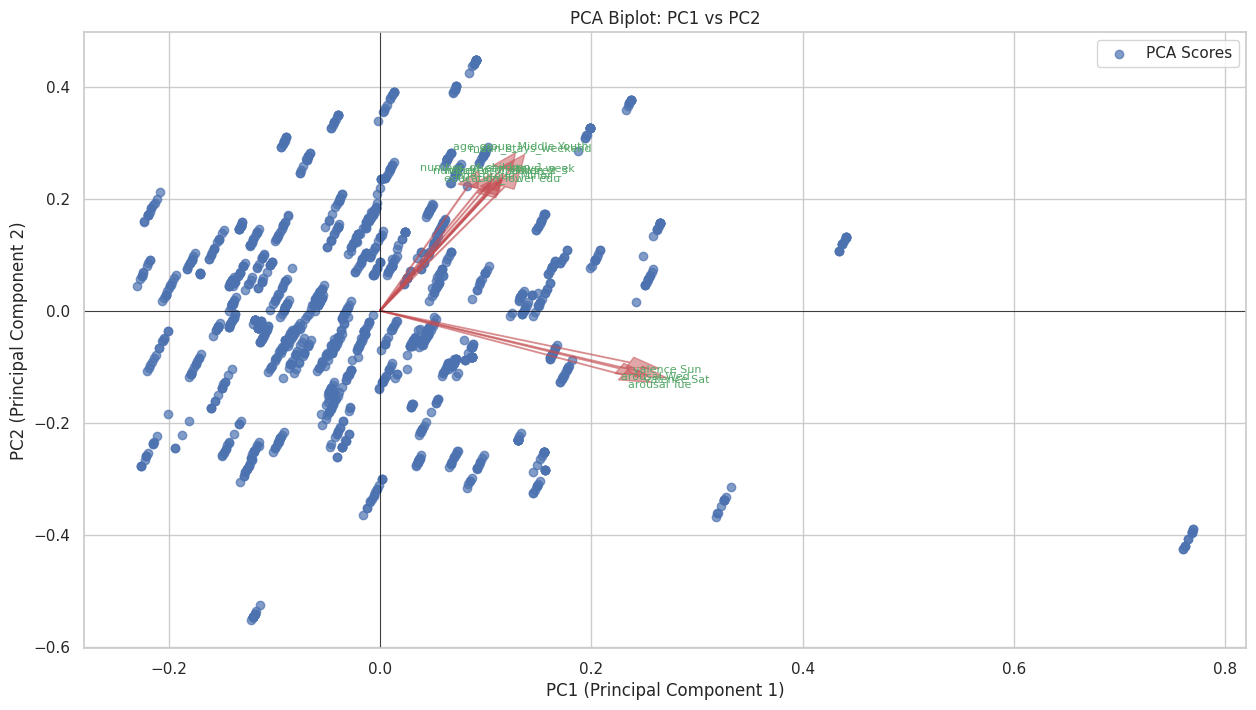

In [428]:
# @title PCA Biplot Analysis

def biplot(score, coeff, labels=None, threshold=0.2):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]

    # Scaling the scores
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    # Plot PCA Scores
    plt.scatter(xs * scalex, ys * scaley, alpha=0.7, color='b', label="PCA Scores")

    # Filter loadings to include only those above a certain threshold
    for i in range(n):
        if np.abs(coeff[i, 0]) > threshold or np.abs(coeff[i, 1]) > threshold:
            plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5, head_width=0.02, head_length=0.03)
            if labels is None:
                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, f"Var{i+1}", color='g', ha='center', va='center', fontsize=8)
            else:
                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='g', ha='center', va='center', fontsize=8)

    # Set labels and title
    plt.xlabel("PC1 (Principal Component 1)")
    plt.ylabel("PC2 (Principal Component 2)")
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    plt.grid(True)
    plt.legend()

# Apply the biplot function with filtering for clearer visualization
plt.figure(figsize=(15, 8))
biplot(features_pca, np.transpose(pca.components_), labels=combined_df.drop('uid', axis=1).columns, threshold=0.2)
plt.title("PCA Biplot: PC1 vs PC2")
plt.show()

PCA Components Shape: (1527, 98)


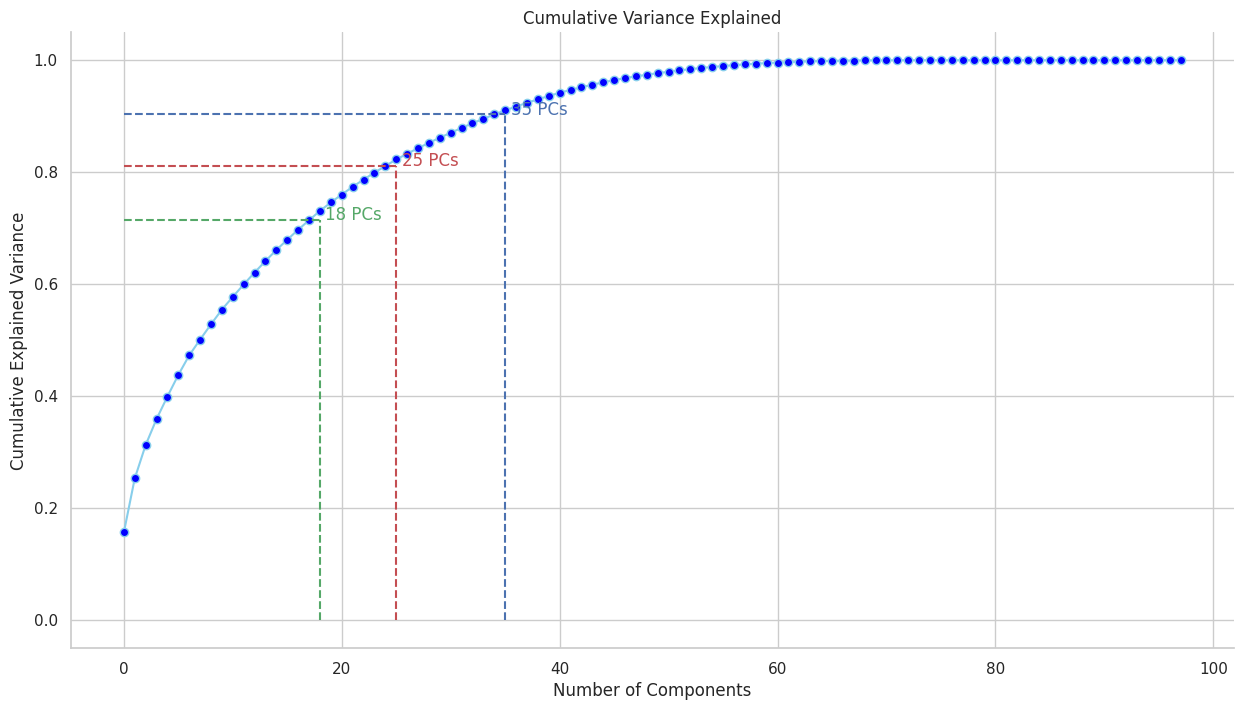

In [429]:
# @title Cumulative Variance Explained

# To check how much variance is explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Explained variance ratio and PCA components shape
variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Variance Explained': cumulative_variance
})

print("PCA Components Shape:", principal_components.shape)
#print("\nExplained Variance Ratio:")
#variance_df.head(10)

variance_df['Cumulative Variance Explained'].plot(marker='o', markerfacecolor='blue', kind='line', color='skyblue', figsize=(15, 8), title='Cumulative Variance Explained')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.gca().spines[['top', 'right']].set_visible(False)

# Calculate the number of PCs needed for each threshold
n_components_70 = variance_df[variance_df['Cumulative Variance Explained'] >= 0.7].index[0] + 1
n_components_80 = variance_df[variance_df['Cumulative Variance Explained'] >= 0.8].index[0] + 1
n_components_90 = variance_df[variance_df['Cumulative Variance Explained'] >= 0.9].index[0] + 1

# Get the y-values for each threshold
y_70 = variance_df['Cumulative Variance Explained'][n_components_70-1]
y_80 = variance_df['Cumulative Variance Explained'][n_components_80-1]
y_90 = variance_df['Cumulative Variance Explained'][n_components_90-1]

# Plot the lines with calculated endpoints
plt.plot([0, n_components_70], [y_70, y_70], color='g', linestyle='--')
plt.plot([n_components_70, n_components_70], [0, y_70], color='g', linestyle='--')
plt.text(n_components_70 + 0.5, y_70, f'{n_components_70} PCs', color='g')

plt.plot([0, n_components_80], [y_80, y_80], color='r', linestyle='--')
plt.plot([n_components_80, n_components_80], [0, y_80], color='r', linestyle='--')
plt.text(n_components_80 + 0.5, y_80, f'{n_components_80} PCs', color='r')

plt.plot([0, n_components_90], [y_90, y_90], color='b', linestyle='--')
plt.plot([n_components_90, n_components_90], [0, y_90], color='b', linestyle='--')
plt.text(n_components_90 + 0.5, y_90, f'{n_components_90} PCs', color='b')

plt.show()

In [430]:
n_components_75 = variance_df[variance_df['Cumulative Variance Explained'] >= 0.75].index[0] + 1
n_components_75

21

In [431]:
pca_data = features_pca[:, :21]  # Use first 21 PCs

# K-Means

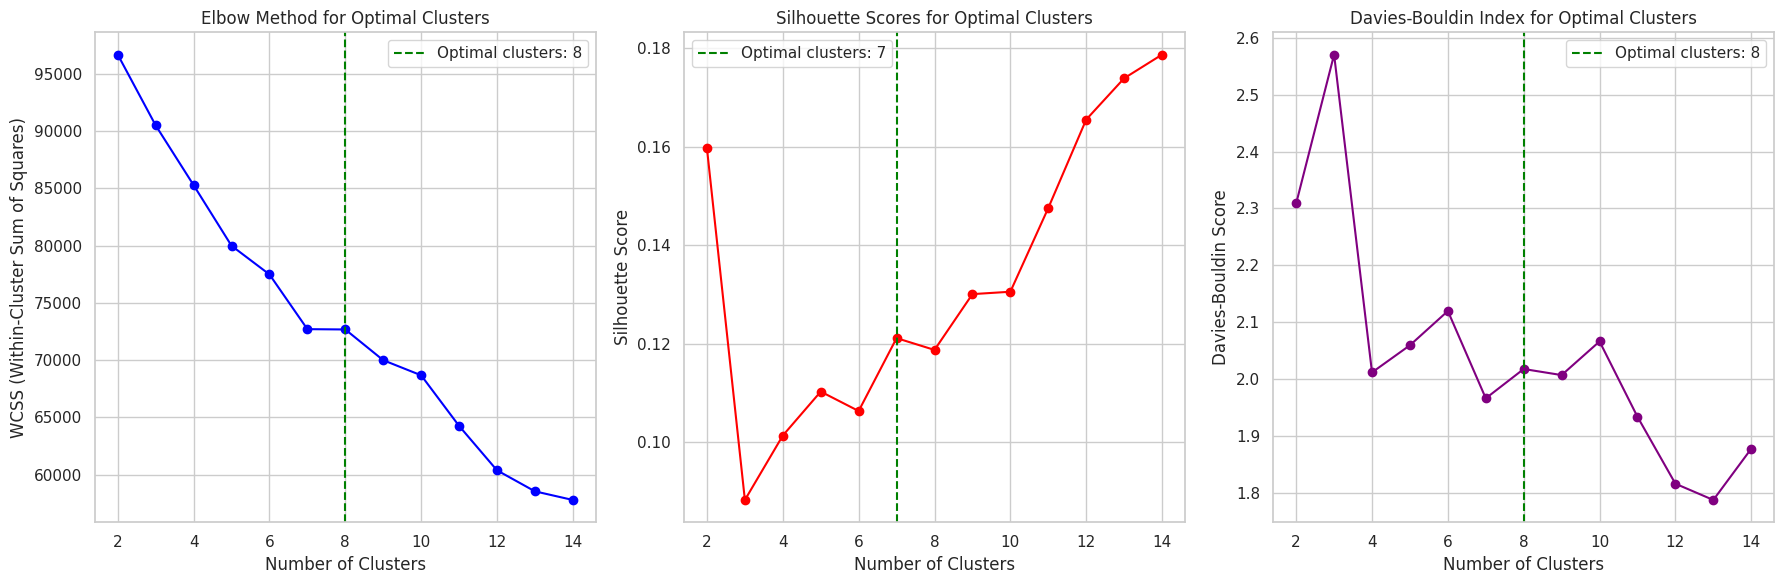

In [432]:
# Import required libraries
from sklearn.metrics import davies_bouldin_score

# Lists to store metrics
wcss = []
silhouette_scores = []
davies_bouldin_scores = []  # Davies-Bouldin Index to validate clustering

cluster_range = range(2, 15)

# Iterate over the range of clusters to calculate metrics
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)

    # Append WCSS for the Elbow Method
    wcss.append(kmeans.inertia_)

    # Calculate silhouette score for each k
    silhouette_avg = silhouette_score(pca_data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    # Calculate Davies-Bouldin Index for further validation
    db_index = davies_bouldin_score(pca_data, kmeans.labels_)
    davies_bouldin_scores.append(db_index)

# Identify the potential optimal clusters based on observation (change based on your analysis)
optimal_clusters_elbow = 8  # Based on the Elbow Method
optimal_clusters_silhouette = 7  # Based on Silhouette Scores
optimal_clusters_DaviesBouldin = 8 # Based on Davies-Bouldin Index

# Create the subplots to visualize Elbow and Silhouette Methods
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: Elbow Method (WCSS)
axs[0].plot(cluster_range, wcss, marker='o', linestyle='-', color='blue')
axs[0].set_title('Elbow Method for Optimal Clusters')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('WCSS (Within-Cluster Sum of Squares)')

# Optimal cluster line for Elbow Method
axs[0].axvline(x=optimal_clusters_elbow, color='green', linestyle='--', label=f'Optimal clusters: {optimal_clusters_elbow}')
axs[0].legend()

# Subplot 2: Silhouette Score
axs[1].plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Silhouette Scores for Optimal Clusters')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Silhouette Score')

# Optimal cluster line for Silhouette Method
axs[1].axvline(x=optimal_clusters_silhouette, color='green', linestyle='--', label=f'Optimal clusters: {optimal_clusters_silhouette}')
axs[1].legend()

# Subplot 3: Davies-Bouldin Index for cluster validation
axs[2].plot(cluster_range, davies_bouldin_scores, marker='o', linestyle='-', color='purple')
axs[2].set_title('Davies-Bouldin Index for Optimal Clusters')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Davies-Bouldin Score')

# Optimal cluster line for Davies-Bouldin Index
axs[2].axvline(x=optimal_clusters_DaviesBouldin, color='green', linestyle='--', label=f'Optimal clusters: {optimal_clusters_DaviesBouldin}')
axs[2].legend()

plt.tight_layout()
plt.show()

In [433]:
# Proceed with K-Means clustering for 8 clusters
kmeans_8 = KMeans(n_clusters=8, random_state=42)
kmeans_8.fit(pca_data)

# Getting the cluster labels
cluster_labels_8 = kmeans_8.labels_

# Adding the cluster labels to the original data for analysis
combined_df['Cluster_8'] = cluster_labels_8

# Display the dataframe with the newly added cluster column
combined_df.columns

Index(['uid', 'dist_to_prev_sum', 'dist_to_prev_mean', 'dist_to_prev_std',
       'mean_trips_week', 'mean_trips_weekday', 'mean_trips_weekend',
       'trips_Mon', 'trips_Tue', 'trips_Wed',
       ...
       'age_group_Minor', 'age_group_Young Youth', 'age_group_Middle Youth',
       'age_group_Elder Youth', 'age_group_Middle Ages',
       'age_group_Elder Ages', 'age_group_Elders', 'region_Rural',
       'region_Urban', 'Cluster_8'],
      dtype='object', length=102)

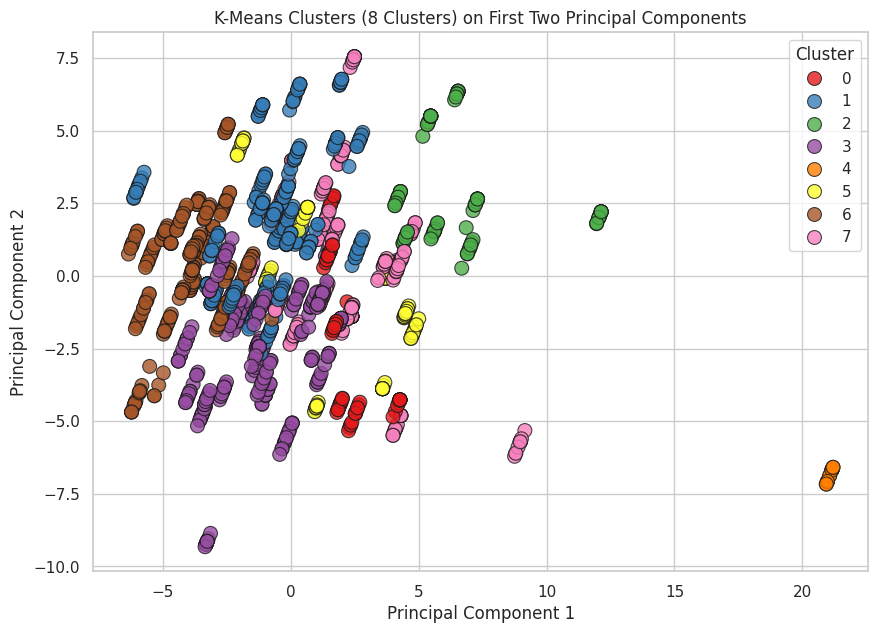

In [434]:
# Create a DataFrame with the first two principal components and cluster labels
pc_df = pd.DataFrame({
    'PC1': principal_components[:, 0],
    'PC2': principal_components[:, 1],
    'Cluster': cluster_labels_8
})

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=100, alpha=0.8, edgecolor='k')

# Add plot title and labels
plt.title('K-Means Clusters (8 Clusters) on First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()

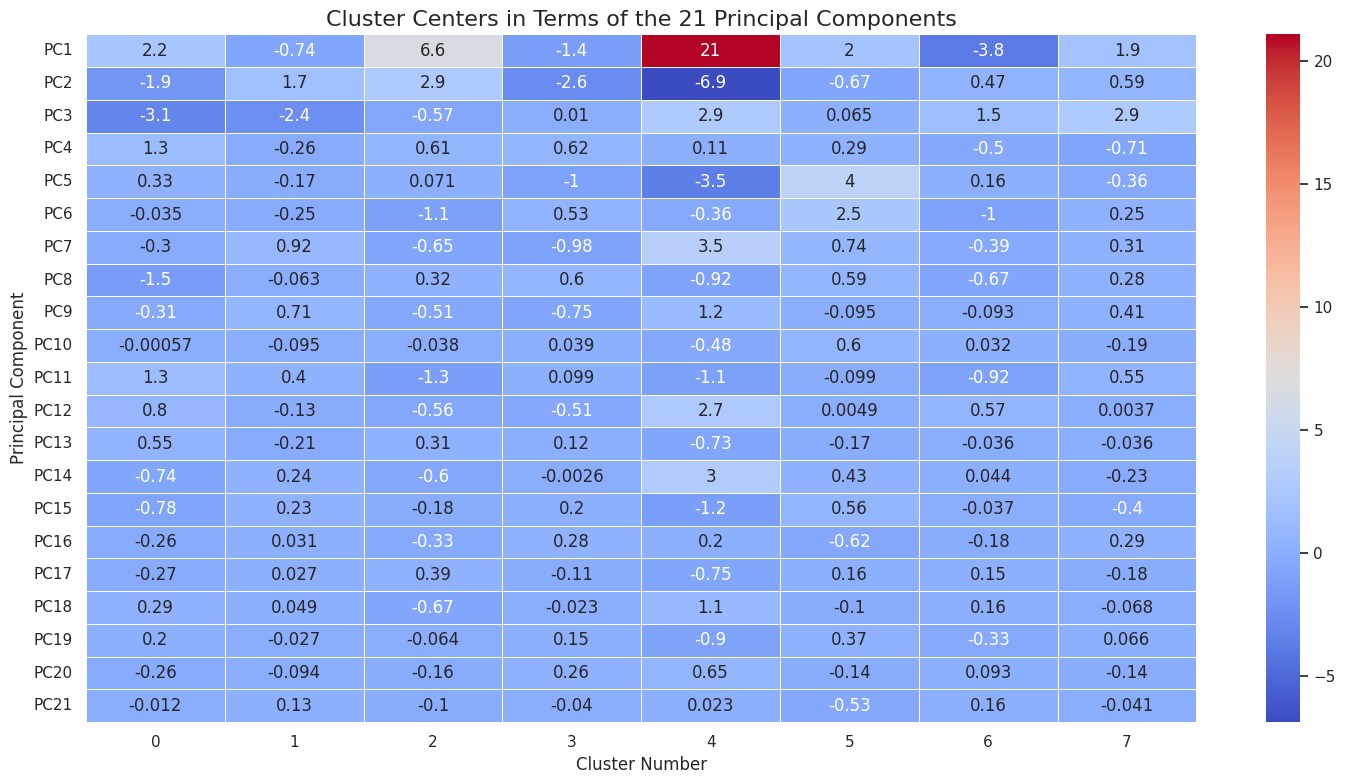

Cluster Centers (First 21 Principal Components):

         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   2.223126 -1.871085 -3.134754  1.266212  0.331229 -0.034907 -0.295210   
1  -0.739801  1.739332 -2.433861 -0.259012 -0.167262 -0.253399  0.920946   
2   6.623887  2.864790 -0.574711  0.605474  0.070999 -1.126489 -0.647987   
3  -1.380635 -2.626415  0.009980  0.615192 -1.016911  0.528136 -0.977392   
4  21.075265 -6.861095  2.927160  0.107727 -3.546999 -0.358609  3.524723   
5   1.981573 -0.666993  0.065247  0.288445  4.039617  2.512120  0.737833   
6  -3.841044  0.474509  1.511844 -0.503997  0.156254 -1.018223 -0.393474   
7   1.916576  0.587318  2.928449 -0.707919 -0.363435  0.248768  0.314233   

        PC8       PC9      PC10  ...      PC12      PC13      PC14      PC15  \
0 -1.509015 -0.314646 -0.000567  ...  0.804853  0.552749 -0.743263 -0.775671   
1 -0.062696  0.705654 -0.094734  ... -0.128556 -0.209627  0.236464  0.232668   
2  0.318528 -0.513034 -0.

In [435]:
# Visualize the cluster centers in terms of the 21 principal components
centers_21pcs = kmeans_8.cluster_centers_[:, :21]  # Cluster centers for all 21 PCs

# Convert the cluster centers into a DataFrame for easier visualization
centers_df = pd.DataFrame(centers_21pcs, columns=[f'PC{i+1}' for i in range(21)])

# Plot the cluster centers for each principal component
plt.figure(figsize=(15, 8))
sns.heatmap(centers_df.T, annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)

# Add plot titles and labels
plt.title('Cluster Centers in Terms of the 21 Principal Components', fontsize=16)
plt.xlabel('Cluster Number', fontsize=12)
plt.ylabel('Principal Component', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

# Optionally, print out the cluster centers DataFrame for further examination
print("Cluster Centers (First 21 Principal Components):\n")
print(centers_df)

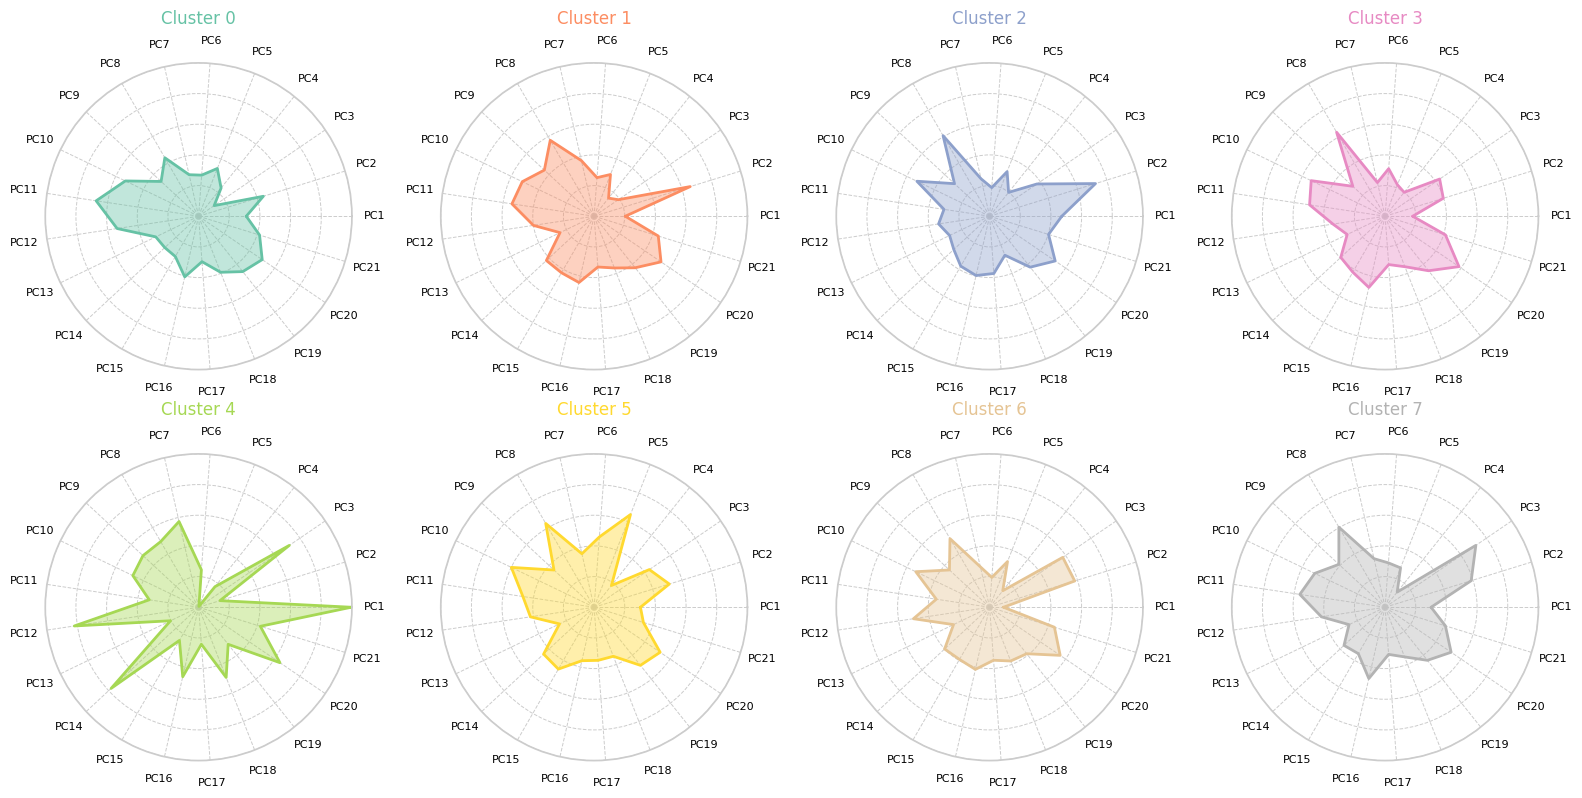

In [436]:
# Set a nice color palette
sns.set(style="whitegrid")

# Function to plot radar chart for a given cluster based on PCs
def plot_radar_chart(ax, cluster_data, cluster_num, labels):
    num_vars = len(labels)

    # Compute angle for each feature
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop" by appending the start to the end.
    cluster_data = pd.concat([cluster_data, cluster_data.iloc[:, 0:1]], axis=1)
    angles += angles[:1]

    # Plot the data with a filled area
    ax.fill(angles, cluster_data.iloc[0].values, color=sns.color_palette('Set2')[cluster_num], alpha=0.4)
    ax.plot(angles, cluster_data.iloc[0].values, color=sns.color_palette('Set2')[cluster_num], linewidth=2)

    # Customize the grid and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8, color='black')
    ax.set_yticklabels([])  # Hide y-tick labels for a cleaner look
    ax.grid(True, linestyle='--', linewidth=0.7)

    # Add title and set limits for radial axis
    ax.set_title(f'Cluster {cluster_num}', size=12, color=sns.color_palette('Set2')[cluster_num], y=1.1)
    ax.set_ylim(0, 1)

# Step 3: Normalize Data for Radar Charts (on Principal Components)
pc_labels = [f'PC{i+1}' for i in range(21)]  # Generate labels for the first 21 PCs
pca_data_df = pd.DataFrame(pca_data, columns=pc_labels)  # Assuming pca_data contains the first 21 PCs

# Normalize features for radar chart
def normalize(df):
    df_norm = df.copy()
    for feature in df.columns:
        max_value = df[feature].max()
        min_value = df[feature].min()
        df_norm[feature] = (df[feature] - min_value) / (max_value - min_value)
    return df_norm

# Normalize the PCA data
pca_data_normalized = normalize(pca_data_df)

# Step 4: Ensure Clusters Are Ordered Correctly (0, 1, 2, 3, 4, 5, 6, 7)
ordered_clusters = sorted(combined_df['Cluster_8'].unique())

# Step 5: Create Subplots for Cluster-Specific Radar Charts using Principal Components
fig, axs = plt.subplots(2, 4, figsize=(16, 8), subplot_kw=dict(polar=True))  # Create a 2x4 grid for 8 clusters

# Flatten axes for easy iteration
axs = axs.flatten()

# Loop through ordered clusters and plot radar charts in subplots
for i, cluster_num in enumerate(ordered_clusters):
    cluster_data = pca_data_normalized[combined_df['Cluster_8'] == cluster_num].mean().to_frame().T
    plot_radar_chart(axs[i], cluster_data, cluster_num, pc_labels)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [437]:
# Group the data by cluster
clustered_data = combined_df.groupby('Cluster_8')

# Calculate summary statistics for each cluster
cluster_summary = clustered_data.mean()  # You can also calculate median, std, etc.
print("Cluster Summary (Means):\n", cluster_summary)

# Display a few rows of the summary to understand key differences
cluster_summary.head()

Cluster Summary (Means):
            dist_to_prev_sum  dist_to_prev_mean  dist_to_prev_std  \
Cluster_8                                                          
0                160.509267           5.246345          7.496609   
1                 68.950756           4.036144          6.185631   
2                197.042248           5.144973          8.459410   
3                101.941368           5.129493          5.658870   
4                133.990039           1.313628          2.871887   
5                571.415109          32.046553         70.708658   
6                 48.684997           6.001589          9.550803   
7                221.304971           8.454445         14.833880   

           mean_trips_week  mean_trips_weekday  mean_trips_weekend  trips_Mon  \
Cluster_8                                                                       
0                 4.420725            4.643182            4.181818   5.363636   
1                 2.826629            2.972332    

<ipython-input-437-00a139aac470>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = clustered_data.mean()  # You can also calculate median, std, etc.


dist_to_prev_sum  dist_to_prev_mean  dist_to_prev_std  \
Cluster_8                                                          
0                160.509267           5.246345          7.496609   
1                 68.950756           4.036144          6.185631   
2                197.042248           5.144973          8.459410   
3                101.941368           5.129493          5.658870   
4                133.990039           1.313628          2.871887   

           mean_trips_week  mean_trips_weekday  mean_trips_weekend  trips_Mon  \
Cluster_8                                                                       
0                 4.420725            4.643182            4.181818   5.363636   
1                 2.826629            2.972332            2.422096   3.022663   
2                 5.702265            6.510680            3.533981   5.495146   
3                 3.507956            3.553506            2.724085   3.853659   
4                14.571429           13.400000           17.500000  14.000000   

           trips_Tue  trips_Wed  trips_Thu  ...  number_of_children_4  \
Cluster_8                                   ...                         
0           4.170455   4.715909   4.863636  ...              0.136364   
1           2.515581   2.019830   2.348442  ...              0.000000   
2           6.203883   6.796117   7.359223  ...              0.000000   
3           2.618902   2.597561   3.082317  ...              0.000000   
4          15.000000  12.000000  13.000000  ...              0.000000   

           age_group_Minor  age_group_Young Youth  age_group_Middle Youth  \
Cluster_8                                                                   
0                      0.0                    0.0                0.000000   
1                      0.0                    0.0                0.000000   
2                      0.0                    0.0                0.000000   
3                      0.0                    0.0                0.042683   
4                      0.0                    0.0                0.000000   

           age_group_Elder Youth  age_group_Middle Ages  age_group_Elder Ages  \
Cluster_8                                                                       
0                       0.318182               0.488636              0.193182   
1                       0.226629               0.620397              0.152975   
2                       0.252427               0.611650              0.135922   
3                       0.667683               0.210366              0.079268   
4                       0.000000               1.000000              0.000000   

           age_group_Elders  region_Rural  region_Urban  
Cluster_8                                                
0                       0.0      0.840909      0.159091  
1                       0.0      0.773371      0.226629  
2                       0.0      0.883495      0.116505  
3                       0.0      0.585366      0.414634  
4                       0.0      1.000000      0.000000  

[5 rows x 98 columns]

<ipython-input-438-8269bff2040e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='Cluster_8', y=feature, palette=cluster_palette)
<ipython-input-438-8269bff2040e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='Cluster_8', y=feature, palette=cluster_palette)
<ipython-input-438-8269bff2040e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='Cluster_8', y=feature, palette=cluster_palette)
<ipython-input-438-8269bff2040e>:20: FutureWarning: 

Passing `palette` without assigning `

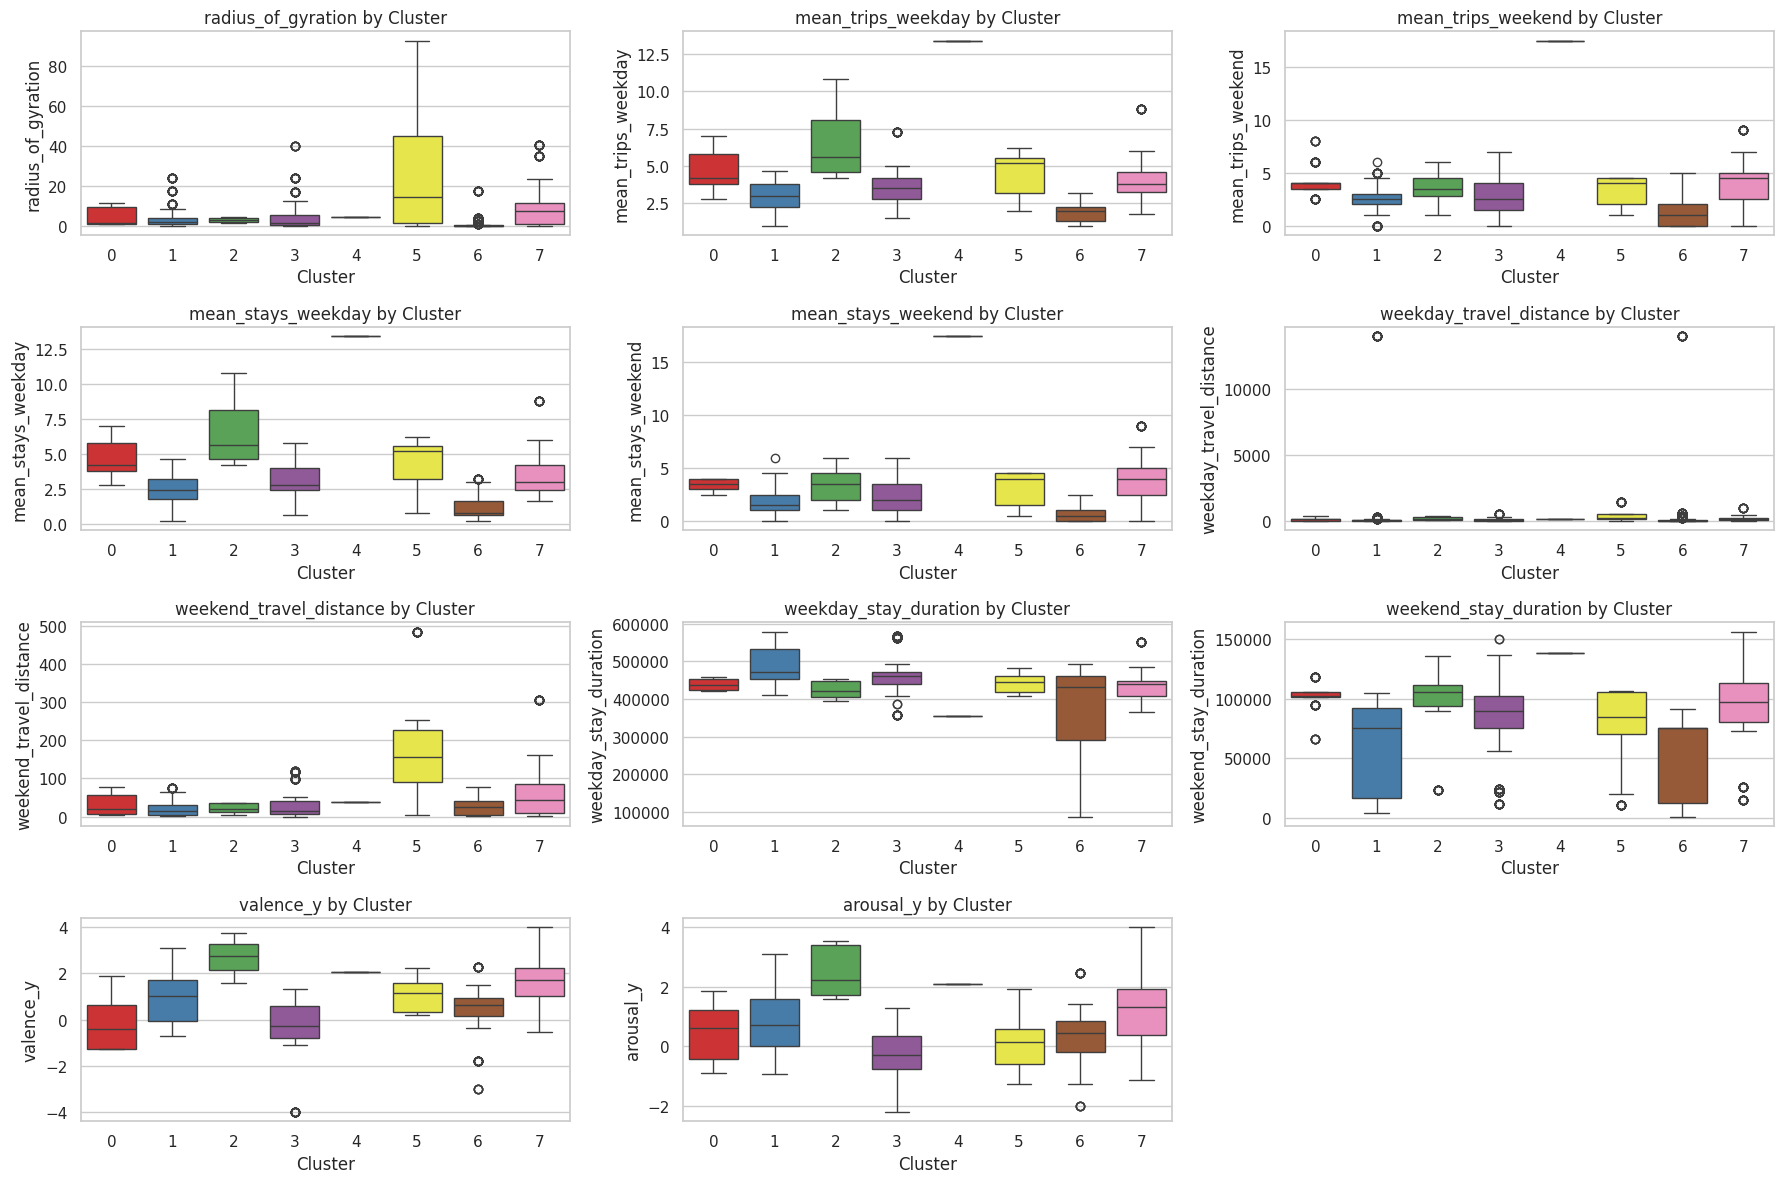

In [438]:
# Set up the plotting grid for numeric features
plt.figure(figsize=(18, 12))

# Define the numeric features
numeric_features = [
    'radius_of_gyration',
    'mean_trips_weekday', 'mean_trips_weekend',
    'mean_stays_weekday', 'mean_stays_weekend',
    'weekday_travel_distance', 'weekend_travel_distance',
    'weekday_stay_duration', 'weekend_stay_duration',
    'valence_y', 'arousal_y'
]

# Set a color palette for clusters
cluster_palette = sns.color_palette("Set1", n_colors=combined_df['Cluster_8'].nunique())

# Create boxplots for numeric features by cluster
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=combined_df, x='Cluster_8', y=feature, palette=cluster_palette)
    plt.title(f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

<Figure size 1800x1500 with 0 Axes>

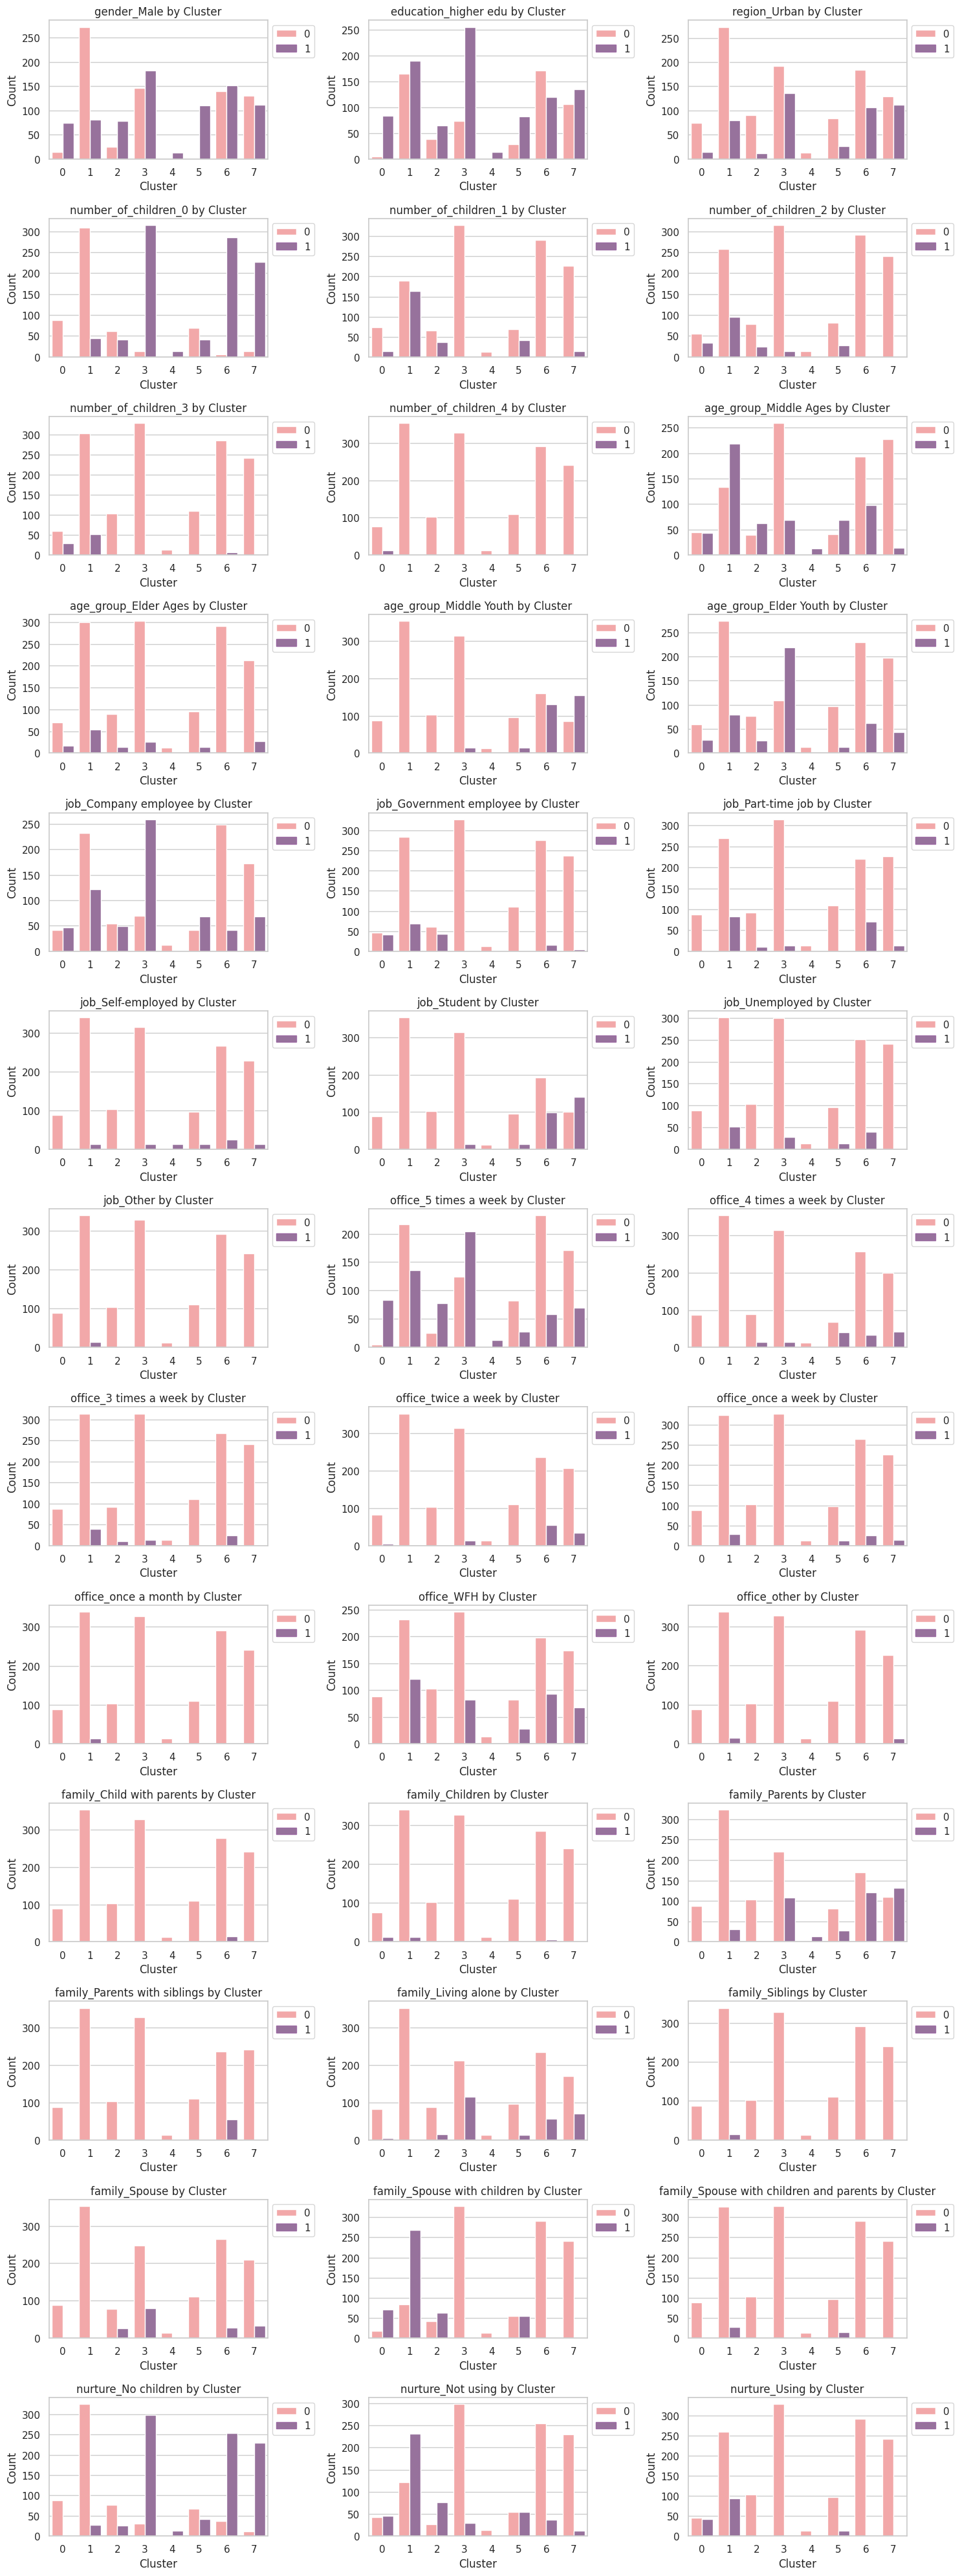

In [439]:
# Visualize Categorical Features by Cluster
plt.figure(figsize=(18, 15))

# Define the categorical features for countplots
categorical_features = [
    'gender_Male', 'education_higher edu', 'region_Urban',
    'number_of_children_0', 'number_of_children_1', 'number_of_children_2', 'number_of_children_3', 'number_of_children_4',
    'age_group_Middle Ages', 'age_group_Elder Ages', 'age_group_Middle Youth', 'age_group_Elder Youth',
    'job_Company employee', 'job_Government employee', 'job_Part-time job', 'job_Self-employed', 'job_Student', 'job_Unemployed', 'job_Other',
    'office_5 times a week', 'office_4 times a week', 'office_3 times a week', 'office_twice a week', 'office_once a week', 'office_once a month', 'office_WFH', 'office_other',
    'family_Child with parents', 'family_Children', 'family_Parents', 'family_Parents with siblings', 'family_Living alone', 'family_Siblings', 'family_Spouse', 'family_Spouse with children', 'family_Spouse with children and parents',
    'nurture_No children', 'nurture_Not using', 'nurture_Using'
]

# Define the custom color palette (highlight "1" in a distinct color)
highlight_color = '#9C6BA3'  # Highlight color for "1"    #FE9C9D D7F0D0 A2C9A1
default_color = '#FE9C9D'    # Default color for other categories  #FAC4CC
custom_palette = {0: default_color, 1: highlight_color}

# Set up the plotting grid with 13 rows and 3 columns for 37 features
plt.figure(figsize=(15, 40))  # Adjust height to fit all the rows

# Create countplots for each categorical feature by cluster
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(13, 3, i)  # 13 rows and 3 columns
    ax = sns.countplot(data=combined_df, x='Cluster_8', hue=feature, palette=custom_palette)
    plt.title(f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')

    # Move the legend outside the plot and highlight '1'
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == '1':
            handle.set_edgecolor(highlight_color)  # Set the edge color of '1' to the highlight color
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

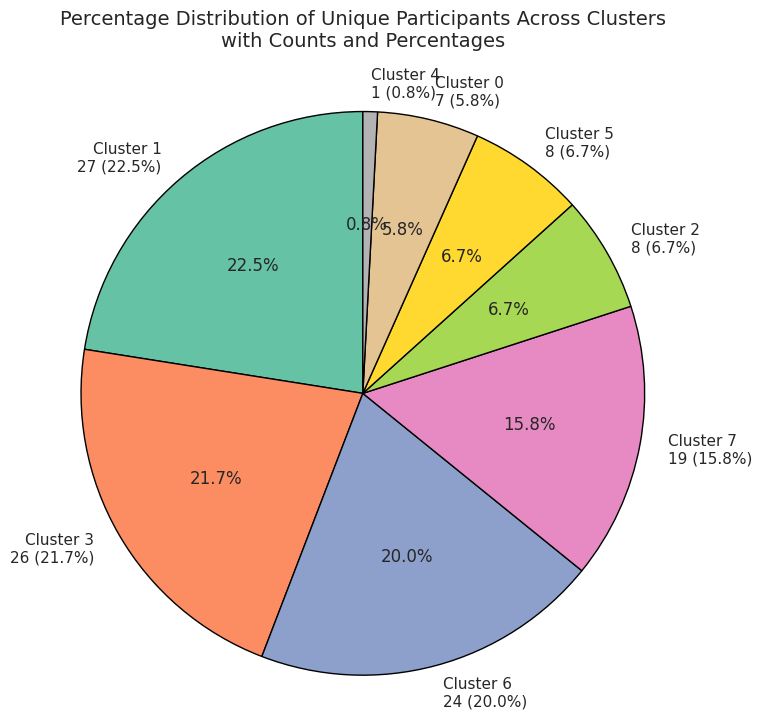

In [440]:
# Assuming 'device_id' is the unique identifier for participants
# First, get the unique participants (device_id) in each cluster
unique_device_ids = combined_df[['uid', 'Cluster_8']].drop_duplicates()

# Calculate the percentage distribution of unique participants across clusters
cluster_counts_unique = unique_device_ids['Cluster_8'].value_counts()
cluster_percentages_unique = (cluster_counts_unique / cluster_counts_unique.sum()) * 100

# Create a pie chart with labels showing percentages and counts for unique participants
plt.figure(figsize=(8, 8))
plt.pie(cluster_percentages_unique, labels=[f'Cluster {i}\n{cluster_counts_unique[i]} ({cluster_percentages_unique[i]:.1f}%)' for i in cluster_counts_unique.index],
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'), wedgeprops={'edgecolor': 'black'})

# Add title and adjust title position to avoid overlap
plt.title('Percentage Distribution of Unique Participants Across Clusters\nwith Counts and Percentages', fontsize=14, y=1.05)

# Ensure the pie chart is a circle
plt.axis('equal')

# Show the plot
plt.show()

In [441]:
# Extract unique participants ('uid') along with their respective clusters
uid_cluster_df = combined_df[['uid', 'Cluster_8']].drop_duplicates()
uid_cluster_df

uid  Cluster_8
0     04c9a764-afd1-4e61-a6ce-775069b1d338          1
14    065e34c8-cacc-4072-81fb-71b250e41b36          3
28    0738c538-8510-4712-8984-fd47447367df          3
42    0839d57b-998b-44b9-bfa7-aaa3a14f164b          3
54    0a796def-4c46-41fe-a0f8-d66b0224124e          7
...                                    ...        ...
1468  eff93d9b-e95b-4d30-a510-43ab06cbc375          6
1481  f3cc4056-d708-4144-9948-eefd6465dee1          3
1496  f40686c5-1afe-45ff-ad1a-a48e9d2b7c63          3
1510  f810aea7-eb0b-4c10-b4a4-43f6f0a98196          6
1514  f858198a-df47-489c-bfa0-f5cff82079a2          3

[120 rows x 2 columns]

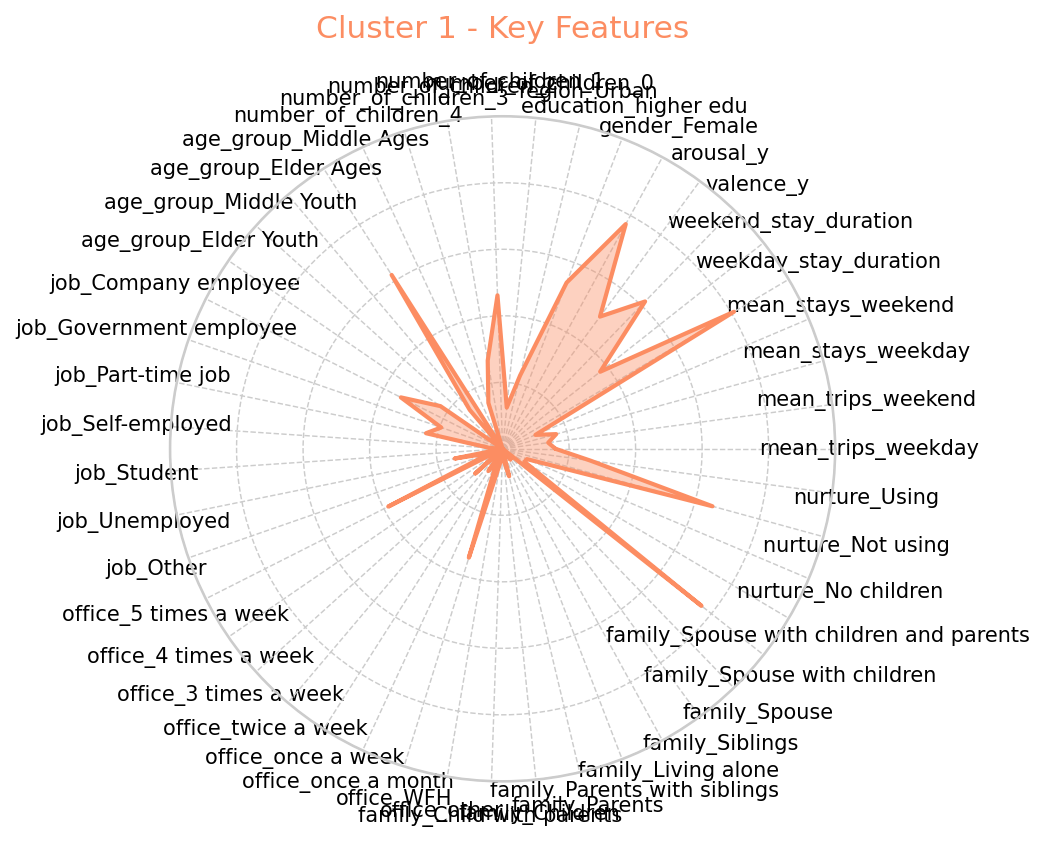

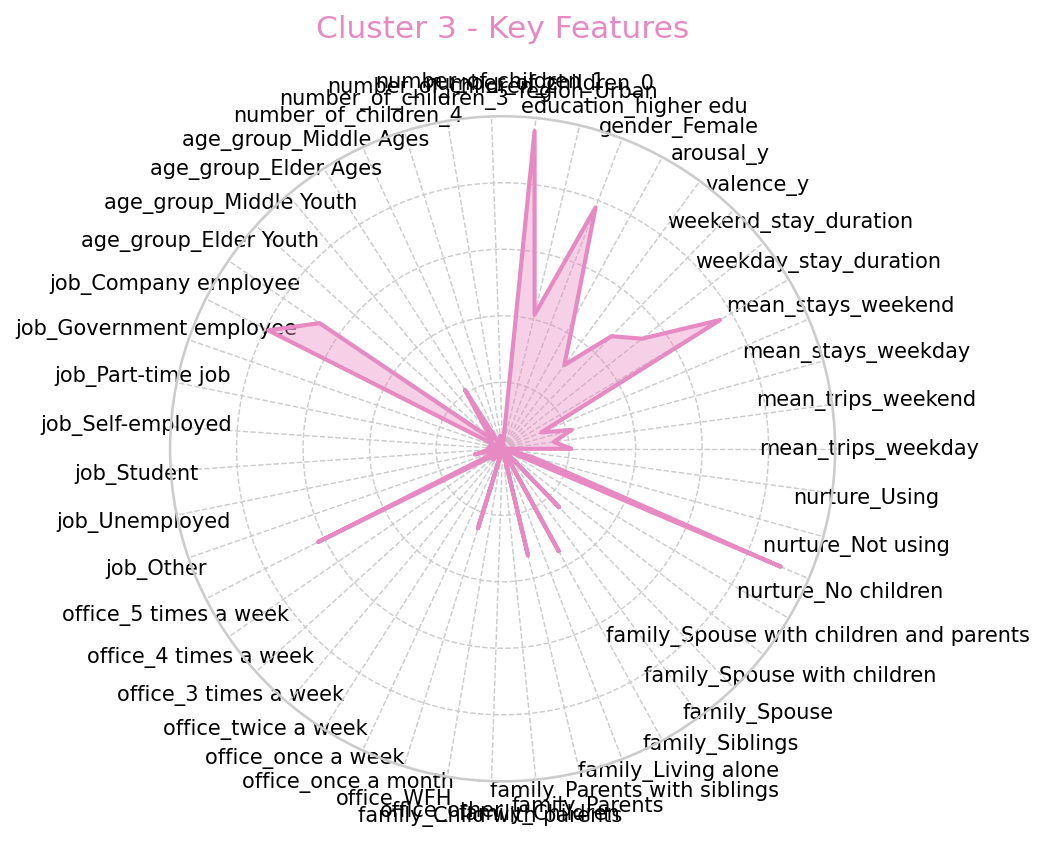

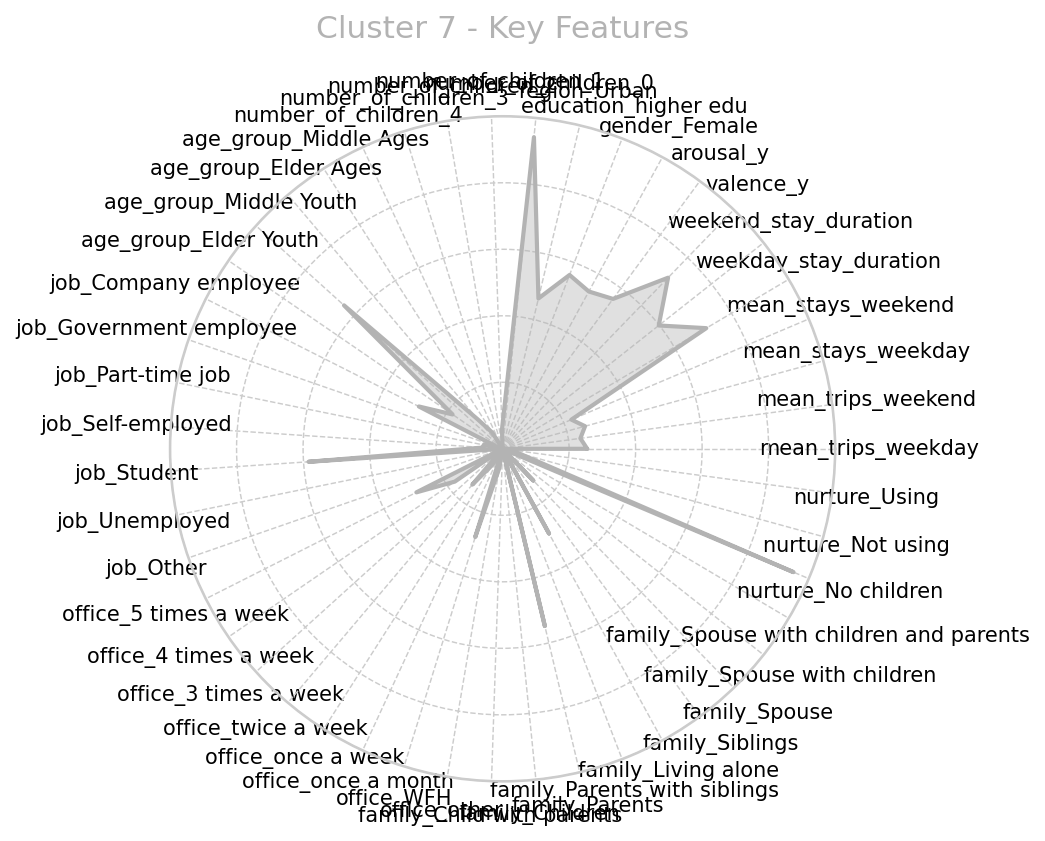

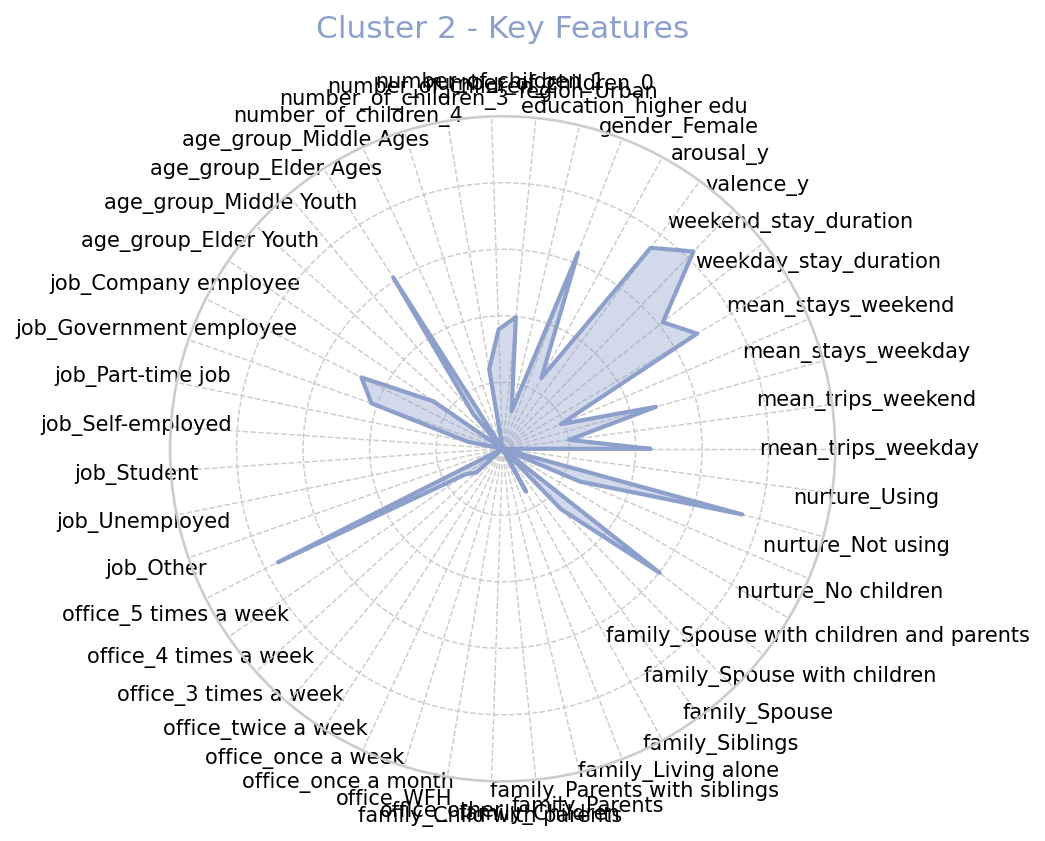

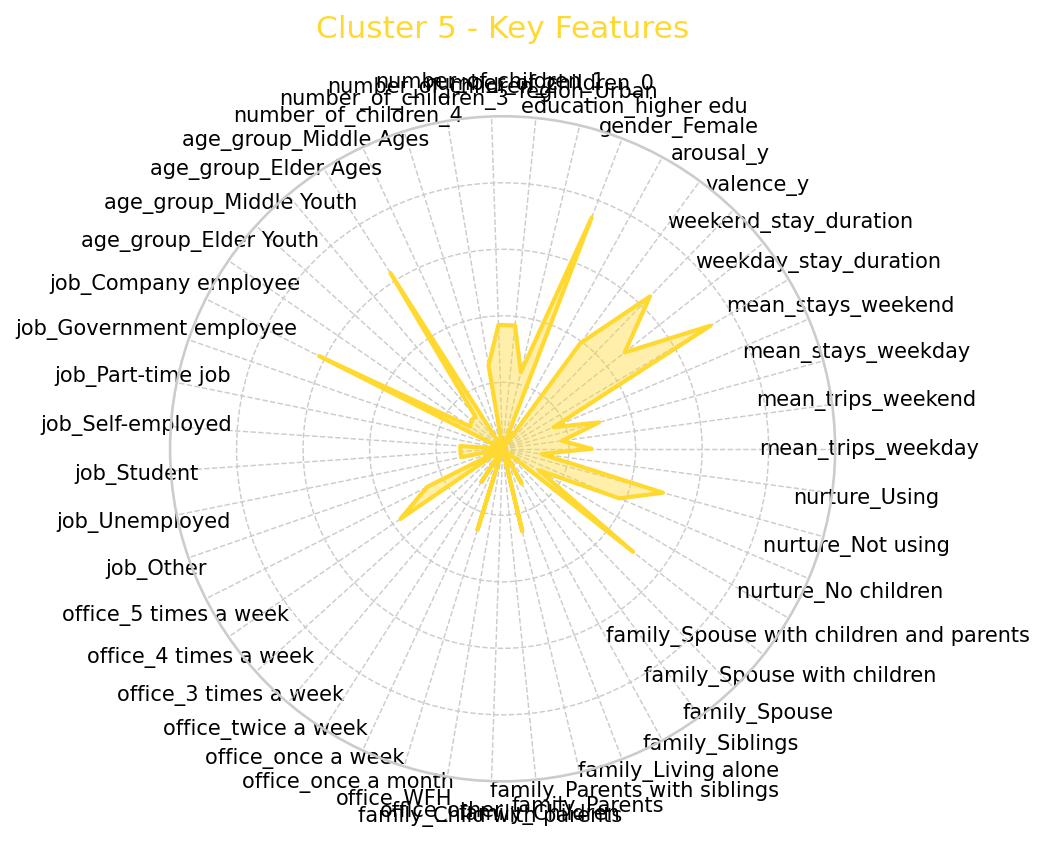

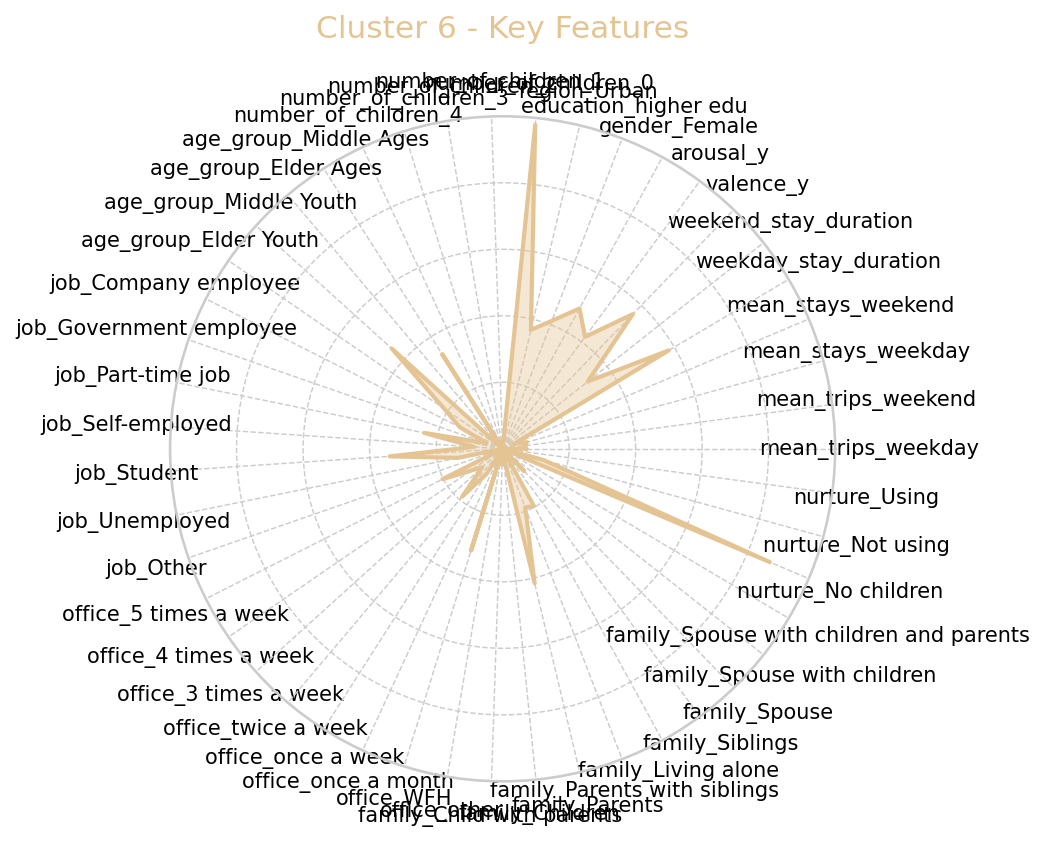

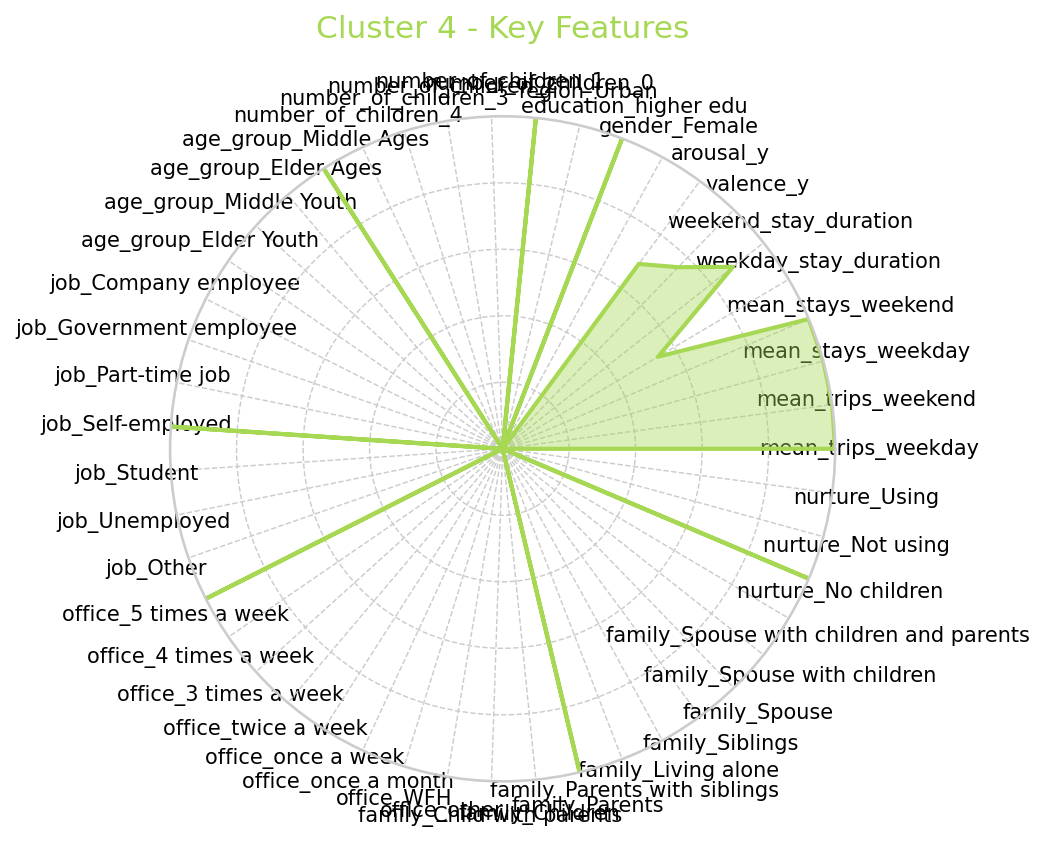

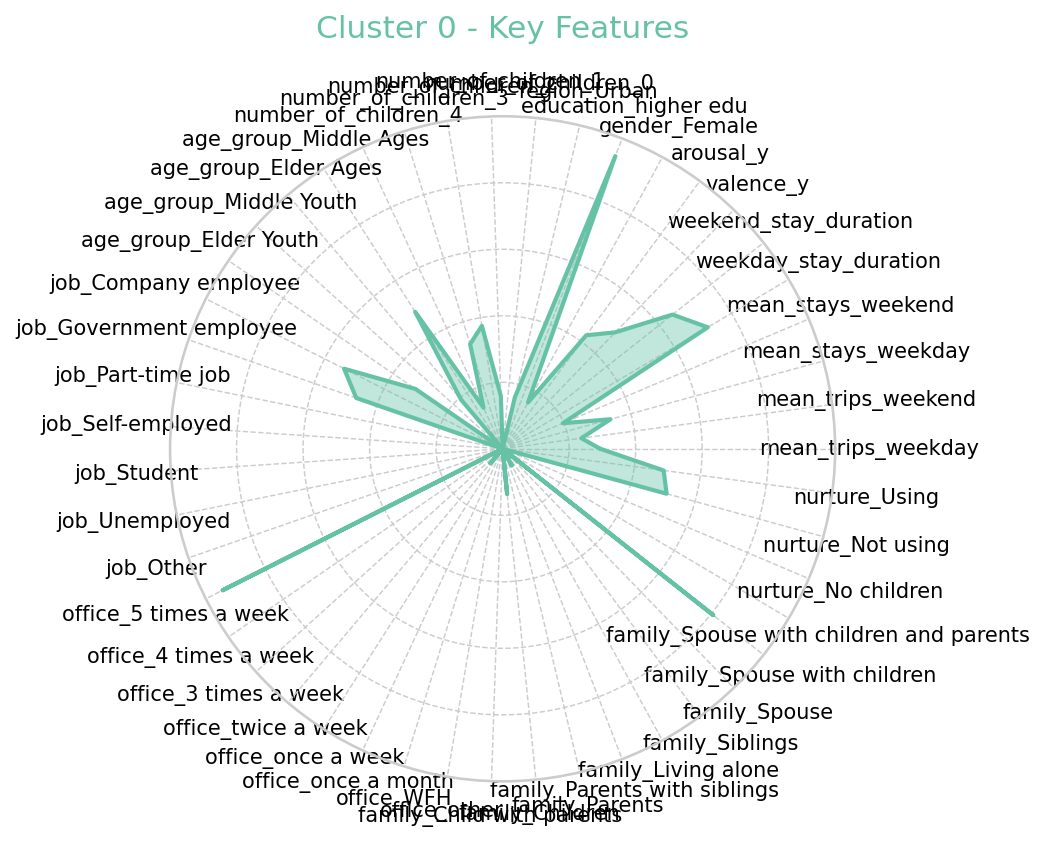

In [442]:
# Set a nice color palette
sns.set(style="whitegrid")

# Function to plot radar chart for a given cluster
def plot_radar_chart(cluster_data, cluster_num):
    # Number of variables we're plotting
    labels = list(cluster_data.columns)
    num_vars = len(labels)

    # Compute angle for each feature
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop" by appending the start to the end.
    cluster_data = pd.concat([cluster_data, cluster_data.iloc[:, 0:1]], axis=1)
    angles += angles[:1]

    # Initialize radar plot with better color and grid design
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True), dpi=150)

    # Plot the data with a filled area
    ax.fill(angles, cluster_data.iloc[0].values, color=sns.color_palette('Set2')[cluster_num], alpha=0.4)
    ax.plot(angles, cluster_data.iloc[0].values, color=sns.color_palette('Set2')[cluster_num], linewidth=2)

    # Customize the grid and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10, color='black')
    ax.set_yticklabels([])  # Hide y-tick labels for a cleaner look
    ax.grid(True, linestyle='--', linewidth=0.7)

    # Add title and set limits for radial axis
    ax.set_title(f'Cluster {cluster_num} - Key Features', size=15, color=sns.color_palette('Set2')[cluster_num], y=1.1)
    ax.set_ylim(0, 1)

    # Add a fill and smooth edge effect
    plt.tight_layout()
    plt.show()

# Step 3: Normalize Data for Radar Charts
key_features = [
    'mean_trips_weekday', 'mean_trips_weekend',
    'mean_stays_weekday', 'mean_stays_weekend',
    'weekday_stay_duration', 'weekend_stay_duration',
    'valence_y', 'arousal_y', 'gender_Female', 'education_higher edu', 'region_Urban',
    'number_of_children_0', 'number_of_children_1', 'number_of_children_2', 'number_of_children_3', 'number_of_children_4',
    'age_group_Middle Ages', 'age_group_Elder Ages', 'age_group_Middle Youth', 'age_group_Elder Youth',
    'job_Company employee', 'job_Government employee', 'job_Part-time job', 'job_Self-employed', 'job_Student', 'job_Unemployed', 'job_Other',
    'office_5 times a week', 'office_4 times a week', 'office_3 times a week', 'office_twice a week', 'office_once a week', 'office_once a month', 'office_WFH', 'office_other',
    'family_Child with parents', 'family_Children', 'family_Parents', 'family_Parents with siblings', 'family_Living alone', 'family_Siblings', 'family_Spouse', 'family_Spouse with children', 'family_Spouse with children and parents',
    'nurture_No children', 'nurture_Not using', 'nurture_Using'
]

# Normalize features (for radar chart)
def normalize(df, features):
    df_norm = df.copy()
    for feature in features:
        max_value = df[feature].max()
        min_value = df[feature].min()
        df_norm[feature] = (df[feature] - min_value) / (max_value - min_value)
    return df_norm

# Normalize combined_df for key features
combined_df_normalized = normalize(combined_df, key_features)

# Step 4: Create Cluster-Specific Radar Charts
for cluster_num in combined_df['Cluster_8'].unique():
    cluster_data = combined_df_normalized[combined_df['Cluster_8'] == cluster_num][key_features].mean().to_frame().T
    plot_radar_chart(cluster_data, cluster_num)

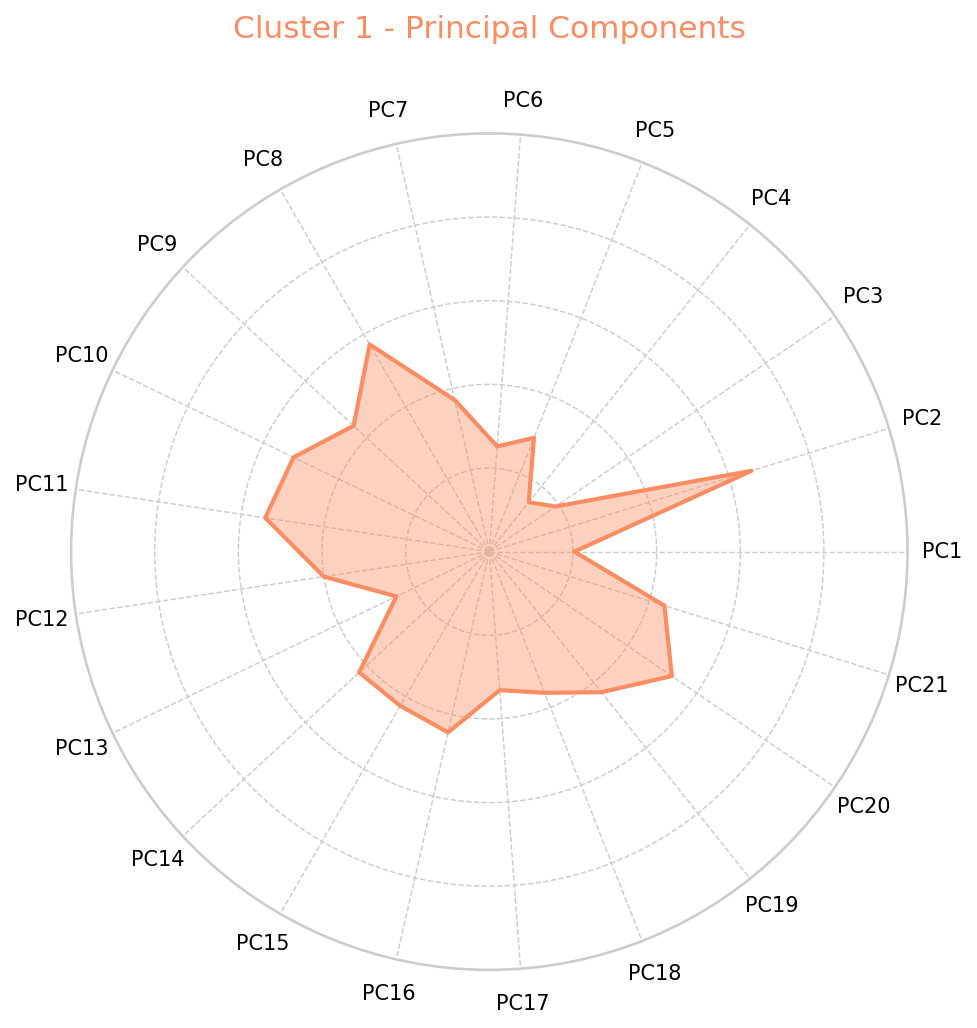

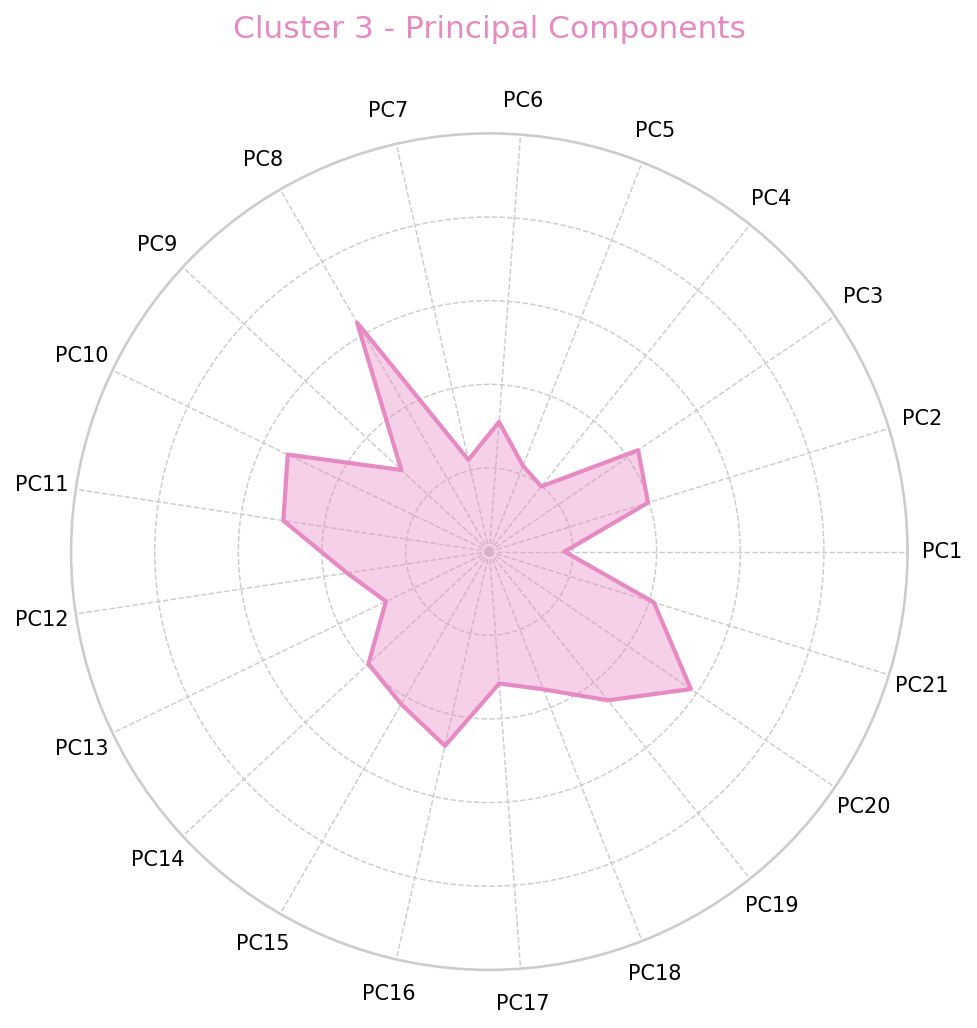

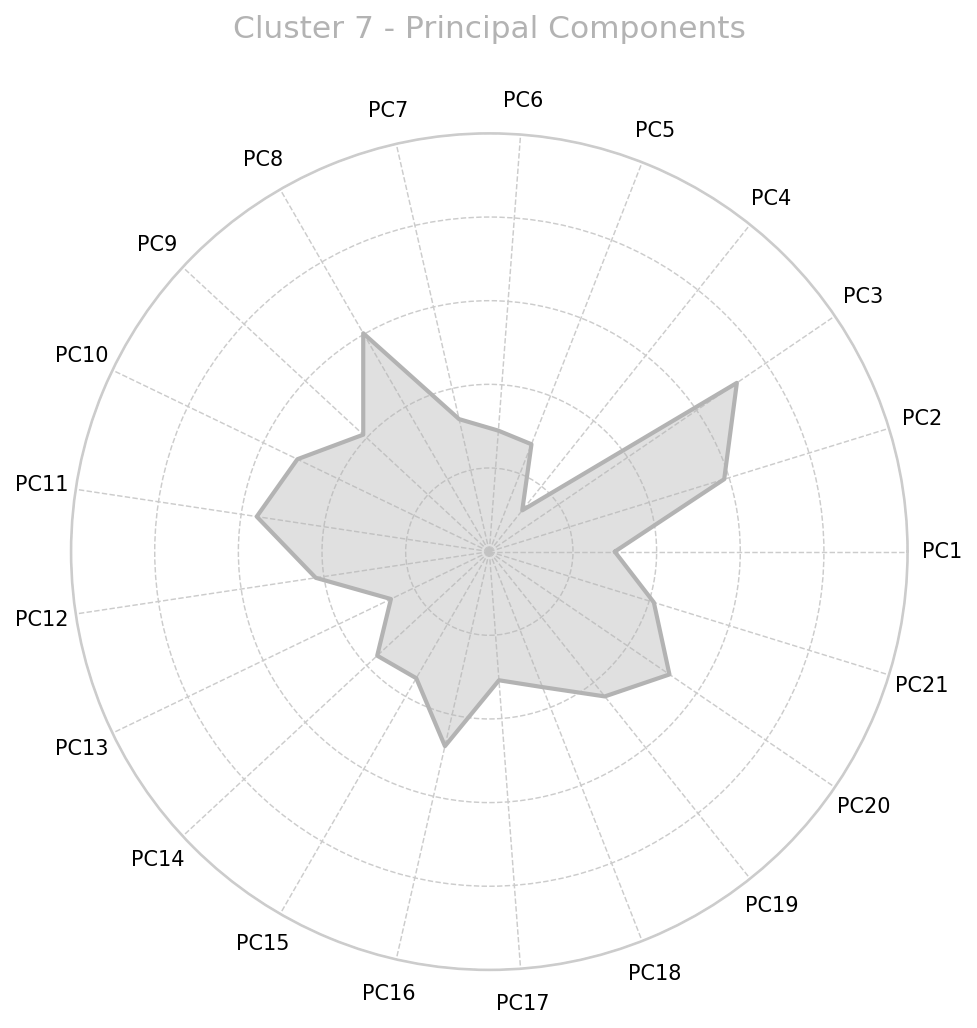

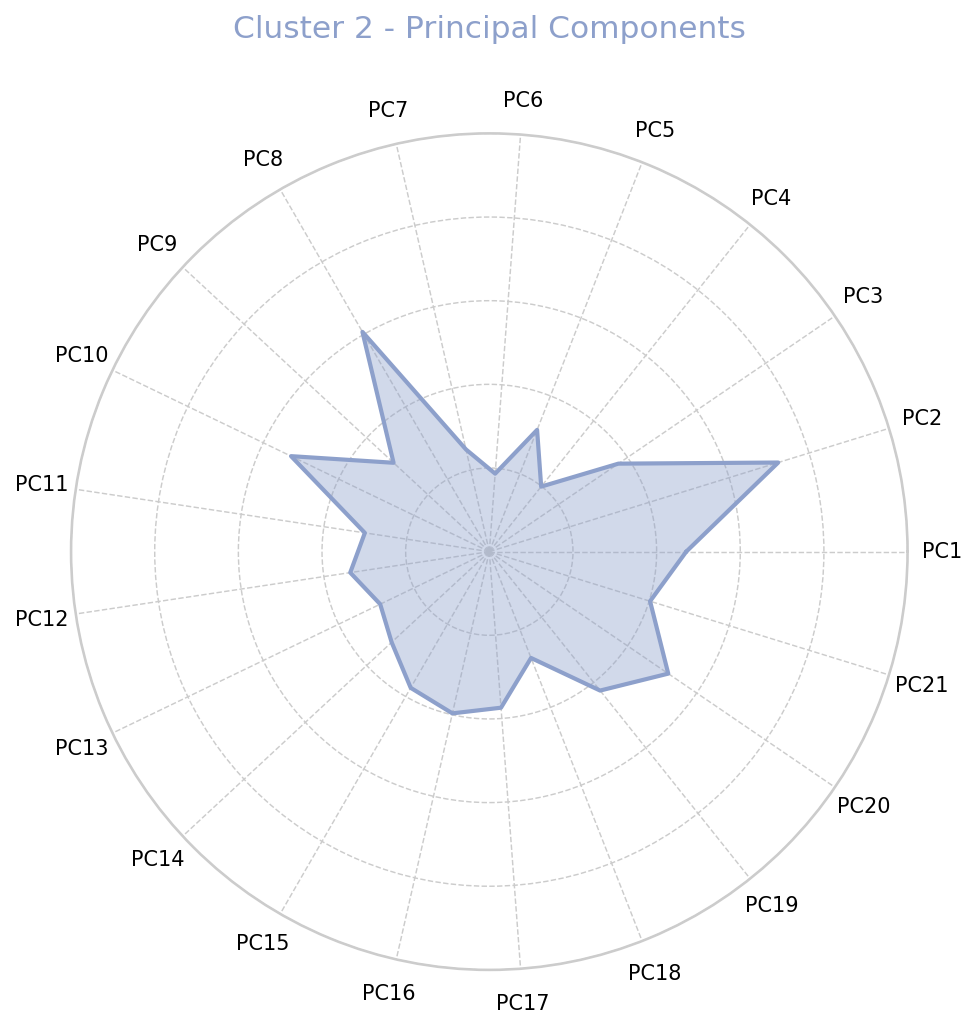

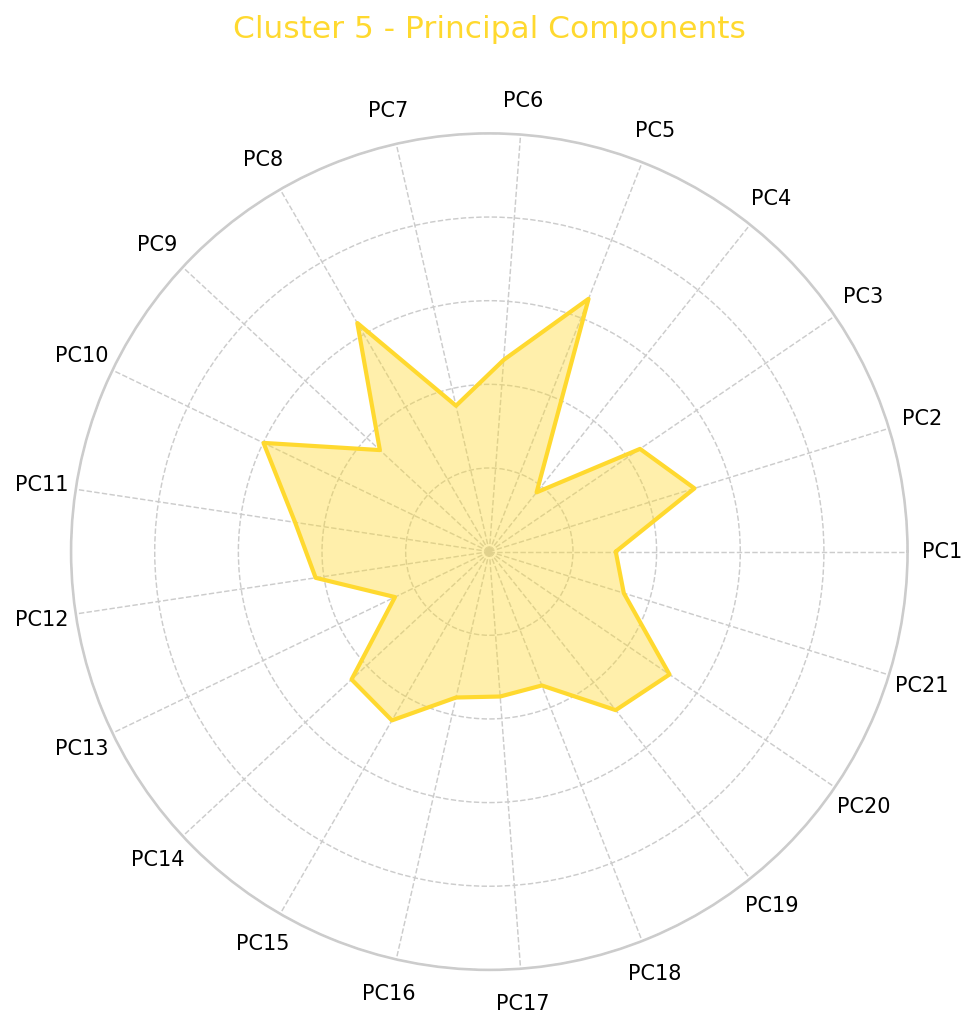

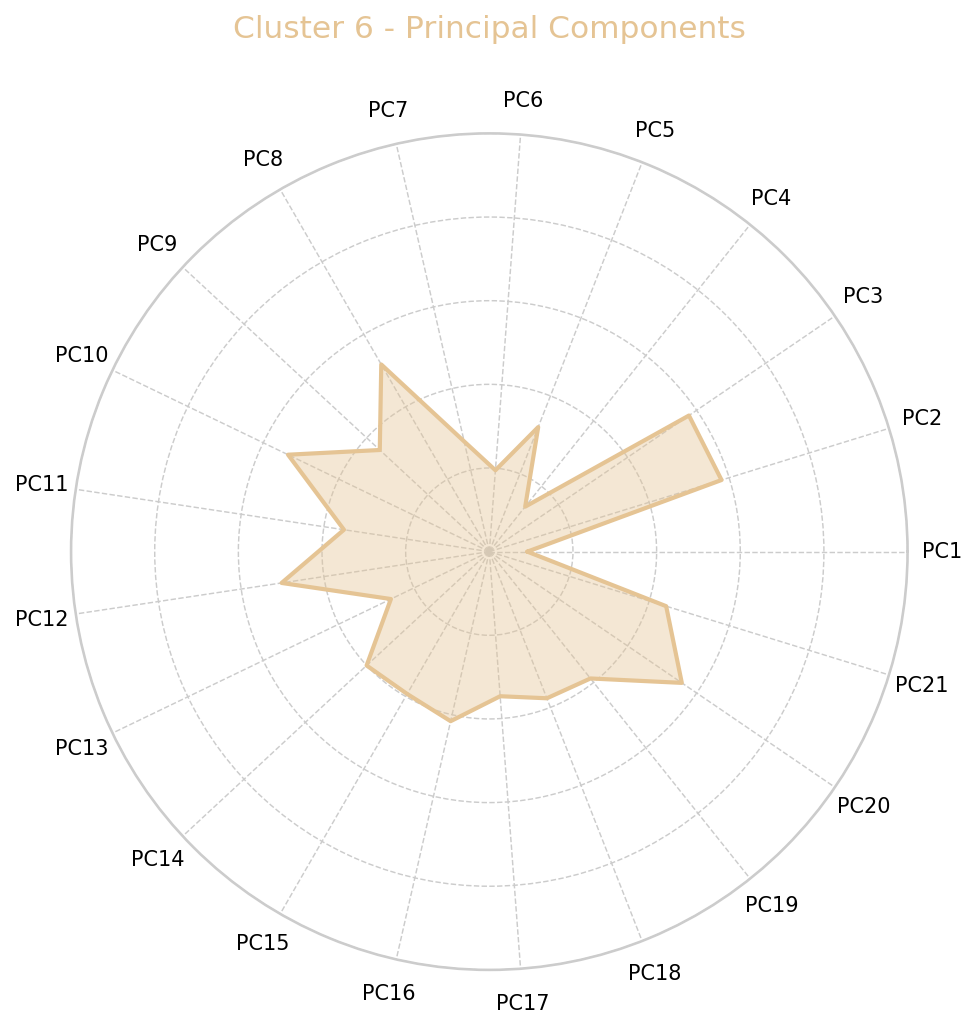

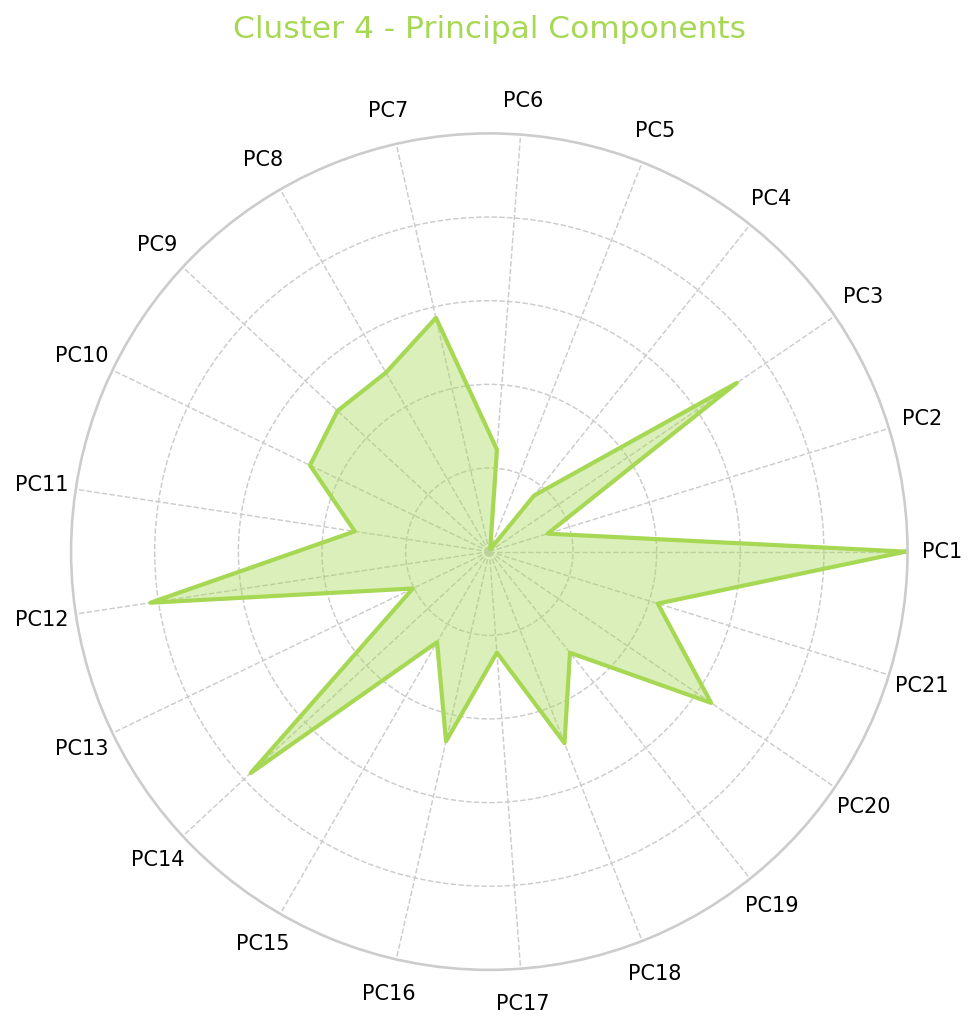

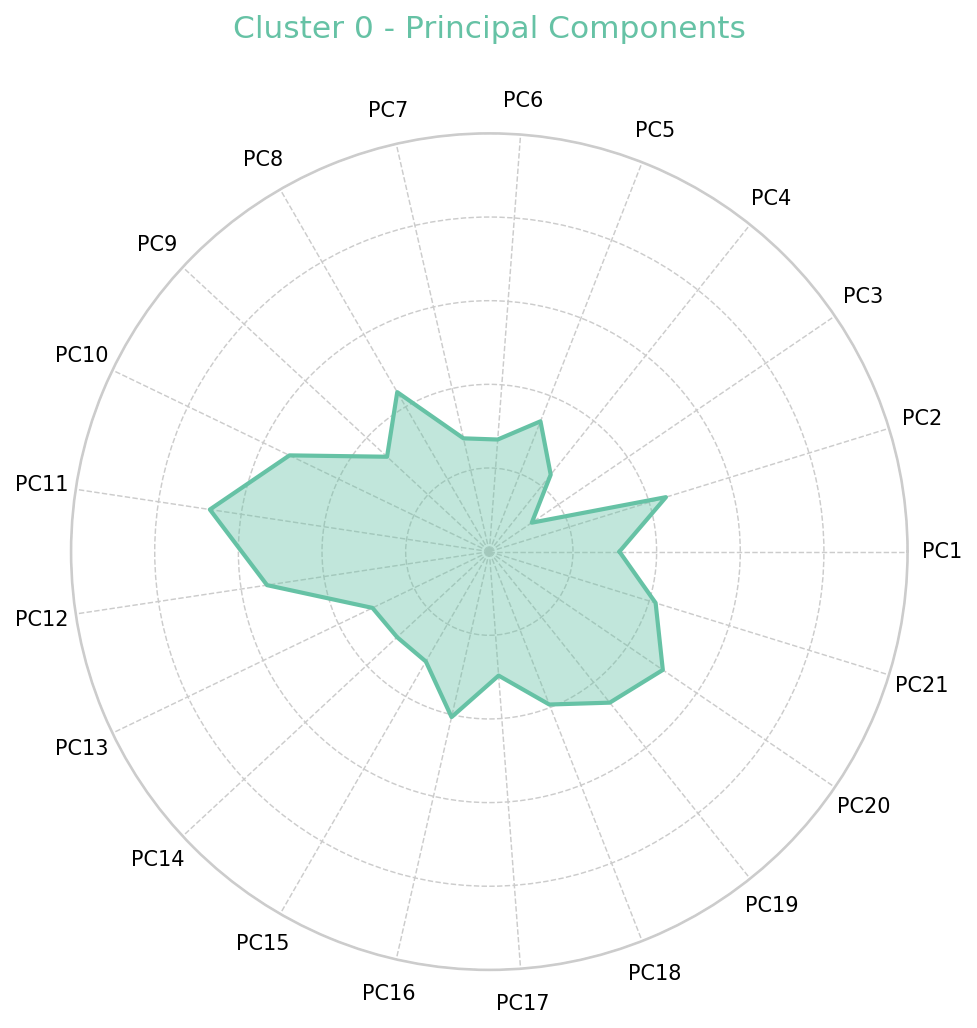

In [443]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns

# Set a nice color palette
sns.set(style="whitegrid")

# Function to plot radar chart for a given cluster based on PCs
def plot_radar_chart(cluster_data, cluster_num, labels):
    num_vars = len(labels)

    # Compute angle for each feature
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop" by appending the start to the end.
    cluster_data = pd.concat([cluster_data, cluster_data.iloc[:, 0:1]], axis=1)
    angles += angles[:1]

    # Initialize radar plot with better color and grid design
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True), dpi=150)

    # Plot the data with a filled area
    ax.fill(angles, cluster_data.iloc[0].values, color=sns.color_palette('Set2')[cluster_num], alpha=0.4)
    ax.plot(angles, cluster_data.iloc[0].values, color=sns.color_palette('Set2')[cluster_num], linewidth=2)

    # Customize the grid and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10, color='black')
    ax.set_yticklabels([])  # Hide y-tick labels for a cleaner look
    ax.grid(True, linestyle='--', linewidth=0.7)

    # Add title and set limits for radial axis
    ax.set_title(f'Cluster {cluster_num} - Principal Components', size=15, color=sns.color_palette('Set2')[cluster_num], y=1.1)
    ax.set_ylim(0, 1)

    # Add a fill and smooth edge effect
    plt.tight_layout()
    plt.show()

# Step 3: Normalize Data for Radar Charts (on Principal Components)
pc_labels = [f'PC{i+1}' for i in range(21)]  # Generate labels for the first 21 PCs
pca_data_df = pd.DataFrame(pca_data, columns=pc_labels)  # Assuming pca_data contains the first 21 PCs

# Normalize features for radar chart
def normalize(df):
    df_norm = df.copy()
    for feature in df.columns:
        max_value = df[feature].max()
        min_value = df[feature].min()
        df_norm[feature] = (df[feature] - min_value) / (max_value - min_value)
    return df_norm

# Normalize the PCA data
pca_data_normalized = normalize(pca_data_df)

# Step 4: Create Cluster-Specific Radar Charts using Principal Components
for cluster_num in combined_df['Cluster_8'].unique():
    cluster_data = pca_data_normalized[combined_df['Cluster_8'] == cluster_num].mean().to_frame().T
    plot_radar_chart(cluster_data, cluster_num, pc_labels)